# Homework 4: Getting to know your customers

Ludovica Mazza, Gabriele Tromboni, Cristiana Di Tullio


## Import libraries

In [ ]:
import pandas as pd
from datetime import datetime
import datetime as dt
import numpy as np
import pickle
from collections import defaultdict
from tqdm import tqdm
import random
import time
import warnings
from sympy import *
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

## 1 - Finding Similar Costumers

Abstract: 
1. Data EDA and cleaning
2. Final data 
3. Minhashing (fingerprint hashing) 
4. LSH (locality sensitive hashing)
5. Retrieve users similar to queries

## 1.1 Set up the data

Downloading **dataset from kaggle**  and **query_users.csv**

In [ ]:
data = pd.read_csv('bank_transactions.csv', delimiter = ',')

In [ ]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [ ]:
query = pd.read_csv('query_users.csv', sep = ',')
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


In [ ]:
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerDOB              50 non-null     object 
 1   CustGender               50 non-null     object 
 2   CustLocation             50 non-null     object 
 3   CustAccountBalance       50 non-null     float64
 4   TransactionDate          50 non-null     object 
 5   TransactionTime          50 non-null     int64  
 6   TransactionAmount (INR)  50 non-null     float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.9+ KB


### Missing values

In [ ]:
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [ ]:
data.dropna(inplace = True)

In [ ]:
query.isna().sum()

CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

### Dates

We've seen that columns as 'CustomerDOB', 'TransactionDate', 'TransactionTime' not have a right format, so convert all them to datetime format. Moreover, we want the date format in the United States.

**Note** that 'TransactionTime' is an int so we want to strip it before to have a right datetime format(H:M:S)

In [ ]:
'''Function to convert dates:
input: a dataframe(dataset or query)
return: dataframe applying conversion of the dates in datetime''' 

def convert_date(df):
    
    df.CustomerDOB = pd.to_datetime(df.CustomerDOB, format = '%d/%m/%y', errors = 'coerce')
    df.TransactionDate = pd.to_datetime(df.TransactionDate, format = '%d/%m/%y', errors = 'coerce')
    df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
    
    return df

In [ ]:
data = convert_date(data)

In [ ]:
query = convert_date(query)

### Customers DOB

Notice that there's a bug time in the date of birth of each customer because some of them were born in the future.

In [ ]:
data.CustomerDOB.value_counts()

1989-01-01    809
1990-01-01    784
1991-08-06    698
1991-01-01    665
1992-01-01    631
             ... 
2005-02-23      1
2042-11-28      1
2049-09-23      1
2040-03-14      1
2044-10-24      1
Name: CustomerDOB, Length: 17232, dtype: int64

In [ ]:
data.TransactionDate.dt.year.value_counts() #dataset was acquired in 2016

2016    1041614
Name: TransactionDate, dtype: int64

<AxesSubplot:>

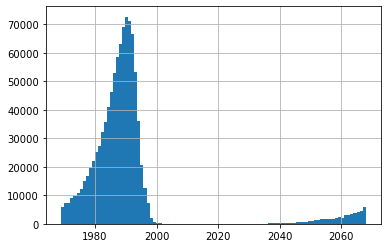

In [ ]:
data.CustomerDOB.dt.year.hist(bins = 100) #problem: people born beyond the present(2016)

Try to fix this problem translating the dates to have a meaningful range like around an entire century(1900-2000):

In [ ]:
data.CustomerDOB.dt.year.min()

1969.0

Even if you can't see it from the histogram above there are people born around 2020

In [ ]:
data[data.CustomerDOB.dt.year.between(1999,2025) == True].head() 

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
270,T271,C2632615,1999-02-18,M,BAGHPAT,10266.36,2016-10-21,1900-01-01 15:23:28,327.0
294,T295,C5411869,1999-12-24,M,BARAMATI,7486.12,2016-10-21,1900-01-01 15:10:37,1000.0
390,T391,C4417679,2021-01-19,M,NEW DELHI,1125922.25,2016-10-21,1900-01-01 20:26:54,4570.0
485,T486,C8013820,2004-07-12,F,CHENNAI,6661.03,2016-10-21,1900-01-01 21:51:49,110.0
734,T735,C1537725,2000-01-13,M,NEW DELHI,854.89,2016-10-21,1900-01-01 22:30:56,275.0


<AxesSubplot:>

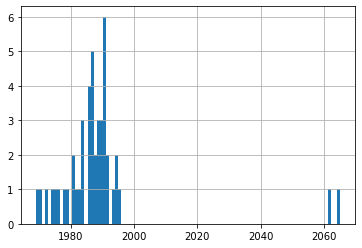

In [ ]:
query.CustomerDOB.dt.year.hist(bins = 100)

In [ ]:
query.CustomerDOB.dt.year.min()

1969.0

We can see that the dataset was acquired in 2016 and all transactions were made at that year, so we was thinking it's right to scale all dates of birth in the range 1920-1998. In this way we'll have people over 18th year and at most 90s

In [ ]:
'''Function to clean and adjust dates:
input: a dataframe(dataset or query)
return: dataframe applying adjustments to avoid wierd distribution about age of customers''' 

def clean_date(df):
    
    df.loc[df.CustomerDOB.dt.year > 1998, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 1998, 'CustomerDOB'] - pd.DateOffset(years = 100)
    df.loc[df.CustomerDOB.dt.year < 1916, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year < 1916, 'CustomerDOB'] + pd.DateOffset(years = 50)
    
    return df

In [ ]:
data = clean_date(data)

In [ ]:
query = clean_date(query)

Now we have a better distribution of birth's dates

<AxesSubplot:>

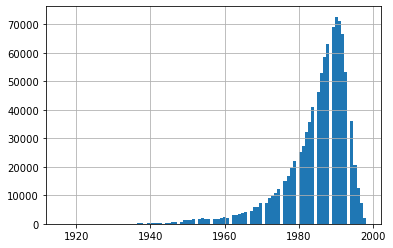

In [ ]:
data.CustomerDOB.dt.year.hist(bins = 100)

<AxesSubplot:>

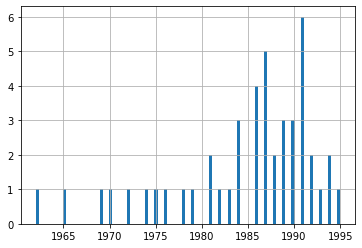

In [ ]:
query.CustomerDOB.dt.year.hist(bins = 100)

### Customer Age

We define a new feature: customer age. We need to state a rule to compute it, for example taking a fixed year, 2016 was the moment in which the dataset was acquired and replace the date of birth with this new feature to simplify our research

In [ ]:
pd.to_datetime('2016') - data.CustomerDOB.loc[0]

Timedelta('8026 days 00:00:00')

In [ ]:
int((pd.to_datetime('2016') - data.CustomerDOB.loc[0]) / np.timedelta64(1, 'Y')) #age of the youngest user

21

There are few missing values to drop

In [ ]:
data.isna().sum()

TransactionID                  0
CustomerID                     0
CustomerDOB                56292
CustGender                     0
CustLocation                   0
CustAccountBalance             0
TransactionDate                0
TransactionTime                0
TransactionAmount (INR)        0
dtype: int64

In [ ]:
query.isna().sum()

CustomerDOB                4
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [ ]:
data.dropna(inplace = True)

In [ ]:
query.dropna(inplace=True)

In [ ]:
'''Function to compute age of users:
input: a dataframe(dataset or query)
return: dataframe replacing date of birth with the age of customers''' 


def compute_age(df):
    
    df['CustomerDOB'] = round((pd.to_datetime('2016') - df.CustomerDOB) / np.timedelta64(1, 'Y'), 0).astype('int64')
    
    return df

In [ ]:
data = compute_age(data)

In [ ]:
query = compute_age(query)

### Transaction date

Since all transactions were made in 2016, let's see what useful information to take from the transaction date between the month and the day

<AxesSubplot:ylabel='Frequency'>

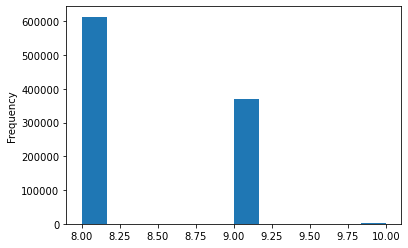

In [ ]:
data.TransactionDate.dt.month.plot.hist(bins = 12) 
# all transaction were made in only three months(August, September and October), not really useful to analyze user's habits

<AxesSubplot:ylabel='Frequency'>

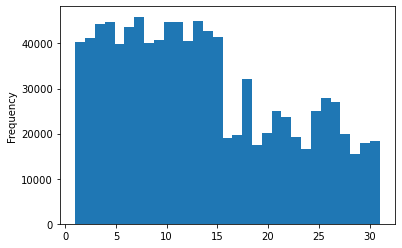

In [ ]:
data.TransactionDate.dt.day.plot.hist(bins = 31) 
# transactions cover all days of the month, so pick this feature to split users in different classes of similarity 

As we can see there are problems with months missed, so in this column we'll take only the day as a discriminant information 

In [ ]:
'''Function to replace date of a single transaction:
input: a dataframe(dataset or query)
return: dataframe replacing transaction date with the day in which was made'''

def day_transaction(df):
    
    df.TransactionDate = df.TransactionDate.dt.day
    
    return df

In [ ]:
data = day_transaction(data)

In [ ]:
query = day_transaction(query)

### Transaction time

For us the right information to extract from transaction time is the hour that explain the most habits of users

<AxesSubplot:ylabel='Frequency'>

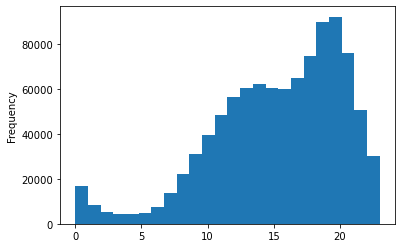

In [ ]:
data.TransactionTime.dt.hour.plot.hist(bins = 24) 
# no problems with this feature, cover all time intervals(hours) in a day!!

In [ ]:
'''Function to replace time of a single transaction:
input: a dataframe(dataset or query)
return: dataframe replacing transaction time with the hour in which was made'''

def hour_transaction(df):
    
    df.TransactionTime = df.TransactionTime.dt.hour 
    
    return df

In [ ]:
data = hour_transaction(data)

In [ ]:
query = hour_transaction(query)

### Custom Gender

Replace value of CustomGender column wiith its ASCII value to can work with int type values

In [ ]:
'''Function to replace gender of a user with its ASCII value:
input: a dataframe(dataset or query)
return: dataframe replacing gender of a user with its ASCII value'''

def convert_gend(df):
    
    df['CustGender'] = df['CustGender'].apply(ord)
    
    return df

In [ ]:
data = convert_gend(data)

In [ ]:
query = convert_gend(query)

### Transaction Amount and CustAccountBalance

We want to get similar users based on band of ages and habits such as how much money have in balance or the amount of their transaction, so we can divide these features in several classes. In particular for 'CustAccountBalance' and 'TransactionAmount(INR)' we pick 20 quartiles, it means that a 5% variation between the minimum and maximum value in the dataset results in a different class.

In [ ]:
'''Function to divide columns in different classes of similarity:
input: a dataframe(dataset or query)
return: dataframe modifying column's values to have final dataframe to work with'''

def ultimate_clean(df):
    
    df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'] * (0.012) # conversion in USD
    
    quant_am, quant_Amount = pd.qcut(df['TransactionAmount (INR)'], q=20, 
                                  labels = [1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100], retbins = True)
    df['TransactionAmount (INR)'] = quant_am  # divide in 20 quartiles and assign new values(labels)
    
    quant_bal, quant_Balance = pd.qcut(df.CustAccountBalance, q = 20, 
                                   labels = [2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], retbins = True)
    df.CustAccountBalance = quant_bal  # divide in 20 quartiles and assign new values(labels)
    
    df.CustomerDOB = pd.cut(df.CustomerDOB, bins = [0, 25, 40, 60, 80, 100] , labels = [125, 140, 160, 180, 200])
    # divide in 5 classes and assign new values(labels)
    # 125: people under 25
    # 140: people not too young (25-40)
    # 160: people neither old nor too young 
    # 180: people enough old
    # 200: very old people
    
    
    return df

In [ ]:
data = ultimate_clean(data)

In [ ]:
query = ultimate_clean(query)

Rename columns and latest changes to can work with

In [ ]:
'''Function to rename columns:
input: a dataframe(dataset or query)
return: dataframe replacing column's labels'''

def rename_col(df):
    
    df = df.rename(columns = {'CustomerDOB' : 'CustomerAge', 'TransactionDate' : 'DayTransaction',
                              'TransactionTime' : 'HourTransaction', 'TransactionAmount (INR)' : 'AmountTransaction'})

    return df 

In [ ]:
data = rename_col(data)

In [ ]:
query = rename_col(query)

In [ ]:
data_2 = data.drop(["TransactionID", "CustomerID", "CustLocation"], axis = 1)
data_2.index = range(len(data_2))

In [ ]:
query_2 = query.drop("CustLocation", axis = 1)
query_2.index = range(len(query_2))

Saving final datasets

In [ ]:
data_2.to_pickle('./FILE PKL/final_data.pkl')

In [ ]:
query_2.to_pickle('./FILE PKL/final_query.pkl')

In [ ]:
final_data = pd.read_pickle('./FILE PKL/final_data.pkl')
final_data.head()

,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction
0,125,70,2055,2,14,1005
1,160,77,2020,2,14,1100
2,125,70,2055,2,14,1055
3,160,70,2100,2,14,1090
4,140,70,2035,2,18,1085


In [ ]:
final_query = pd.read_pickle('./FILE PKL/final_query.pkl')
final_query.head()

,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction
0,140,77,2075,2,14,1015
1,125,77,2025,2,12,1100
2,125,77,2020,10,22,1060
3,140,77,2065,29,14,1070
4,125,77,2070,25,23,1020


## 1.2 Fingerprint hashing

Now we can start MinHash process (fingerprint hashing) for both dataframes (dataset and query_users) as follows:

1. Initially, create a **vocabulary of all shingles** (they are all possible values of the dataset, each unique cell)
1. Next step is to create a **dictionary of one_hot vectors**
1. This one will be used to produce a **signature matrix** that represents the fignerprint for each customer

In [ ]:
'''Create a vocabulary of all shingles, useful for next step of the process'''

voc = set()
for i in tqdm(range(len(final_data))):
    for item in final_data.loc[i]:
        voc.add(item)
voc

100%|██████████| 985322/985322 [02:30<00:00, 6537.92it/s]


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 70,
 77,
 125,
 140,
 160,
 180,
 200,
 1005,
 1010,
 1015,
 1020,
 1025,
 1030,
 1035,
 1040,
 1045,
 1050,
 1055,
 1060,
 1065,
 1070,
 1075,
 1080,
 1085,
 1090,
 1095,
 1100,
 2005,
 2010,
 2015,
 2020,
 2025,
 2030,
 2035,
 2040,
 2045,
 2050,
 2055,
 2060,
 2065,
 2070,
 2075,
 2080,
 2085,
 2090,
 2095,
 2100}

In [ ]:
len(voc)

79

We have 79 shingles in total, each of those represent a value of the customer's features  

In [ ]:
with open('./FILE PKL/all_shingles.pkl', 'wb') as f:
    pickle.dump(voc, f)

In [ ]:
with open('./FILE PKL/all_shingles.pkl', 'rb') as f:
    voc = pickle.load(f)

In [ ]:
'''Function to create the dictionary of one_hot vectors:
the keys are our customers of the dataset while the values are a list of 0 and 1.
For each shingle in the vocabulary, if that shingle represent a feature of a customer we'll put 1 else 0'''

def create_onehot(df, vocabulary):
    
    one_hot = defaultdict(list)

    for i in tqdm(range(len(df))):
        customers = np.array([df.iloc[i]])
        one_hot[i] = [1 if shingle in customers else 0 for shingle in voc]
    
    return one_hot

In [ ]:
data_onehot = create_onehot(final_data, voc)

100%|██████████| 985322/985322 [08:06<00:00, 2023.65it/s]


In [ ]:
query_onehot = create_onehot(final_query, voc)

100%|██████████| 46/46 [00:00<00:00, 1760.24it/s]


In [ ]:
len((data_onehot[0]))

79

In [ ]:
one_hot_matrix = pd.DataFrame.from_dict(data_onehot)

In [ ]:
one_hot_matrix_q = pd.DataFrame.from_dict(query_onehot)

Save one_hot matrices

In [ ]:
one_hot_matrix.to_pickle('./FILE PKL/one_hot_matrix.pkl')

In [ ]:
one_hot_matrix_q.to_pickle('./FILE PKL/one_hot_matrix_q.pkl')

In [ ]:
one_hot_matrix = pd.read_pickle('./FILE PKL/one_hot_matrix.pkl')

In [ ]:
one_hot_matrix_q = pd.read_pickle('./FILE PKL/one_hot_matrix_q.pkl')

Now that a 0-1 vector for each user has been obtained, it will be used to produce a signature as follows:

Repeat for  $k$ times, where $k$ is the reduced # of shingles (this is an approximation that conserve more or less the Jaccard similarity):

1. Perform a random shuffling over the elements of the one_hot_matrix columns;
1. Store the index of the first "1" element into the signature matrix for each user;

By doing this we are reducing the dimensions of each vector from $79$ to $50$, this will allow for faster operations on the MinHash algorithm.

In [ ]:
permutations = 50

In [ ]:
'''Function to create the signature matrix:
first, we create a dictionary of hashing values which will be the matrix for both dataframes(dataset and query).
The keys are indexes represent the permutations while the values are lists. 
For each user we'll have 50 numbers, the indexes of the first "1", represent the signature(fingerprint hashing)'''

def create_signature(df):
    
    random.seed(1234) 
    # set a seed for reproducibility and have same permutations on both dataset and query: this conserve similarity.
    hash_matrix = defaultdict(list)

    for i in tqdm(range(permutations)):
        hash_matrix[i] = list(df.sample(frac = 1, random_state = i).reset_index(drop=True).ne(0).idxmax())
    # .sample shuffles all the rows of the matrix
    # .ne(x) looks for the values different from x
    # .idxmax finds the first index between all the indexes with non-zero values
    
    signature_matrix = pd.DataFrame.from_dict(hash_matrix).transpose()
    
    return signature_matrix

In [ ]:
signature_matrix_data = create_signature(one_hot_matrix)

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


In [ ]:
signature_matrix_query = create_signature(one_hot_matrix_q)

100%|██████████| 50/50 [00:00<00:00, 703.84it/s]


Save and display signature matrices

In [ ]:
signature_matrix_data.to_pickle('./FILE PKL/sign_matrix_data.pkl')

In [ ]:
signature_matrix_query.to_pickle('./FILE PKL/sign_matrix_query.pkl')

In [ ]:
signature_matrix_data = pd.read_pickle('./FILE PKL/sign_matrix_data.pkl')

In [ ]:
signature_matrix_query = pd.read_pickle('./FILE PKL/sign_matrix_query.pkl')

In [ ]:
signature_matrix_data.head()

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,9,3,9,3,0,1,9,12,12,12,...,5,9,6,27,0,6,9,20,4,27
1,17,0,2,0,7,0,12,17,17,17,...,3,14,7,6,50,7,2,25,20,5
2,7,9,7,7,7,7,7,17,7,20,...,7,7,20,19,12,20,0,20,20,20
3,4,11,4,4,4,4,4,13,4,13,...,4,4,13,13,9,13,2,13,0,13
4,13,13,13,13,10,14,36,26,4,4,...,30,30,30,9,10,30,30,18,28,26


In [ ]:
signature_matrix_query.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1,9,5,2,9,8,7,9,19,3,...,13,27,17,9,3,27,3,9,4,8
1,1,17,3,25,29,2,11,17,25,0,...,23,14,5,47,0,4,0,29,20,25
2,9,12,11,0,2,3,7,12,20,9,...,5,9,7,7,5,7,4,9,7,3
3,7,9,9,2,9,1,4,6,13,22,...,13,13,4,3,30,4,32,9,0,1
4,0,32,20,13,7,4,33,3,1,2,...,12,4,20,3,12,17,36,13,4,5


Now implement our version of Locality-Sensitive Hashing. We use a band structure on the signature matrix. If the matrix has $n$ rows, then we divide it into $b$ bands each of width $r$, such that  $n = b * r$

By dividing the signature matrix in this way allows us to maintain similarity across users. In fact, the LSH algorithm is used to search for similar users, with the same habits, with an approximation of true Jaccard Similarity

As a first step take  the first 50 (# permutations) prime numbers useful for compute hash values of the buckets

In [ ]:
primes_range = [i for i in range(2, 233) if isprime(i)] 
primes_range

[2,
 3,
 5,
 7,
 11,
 13,
 17,
 19,
 23,
 29,
 31,
 37,
 41,
 43,
 47,
 53,
 59,
 61,
 67,
 71,
 73,
 79,
 83,
 89,
 97,
 101,
 103,
 107,
 109,
 113,
 127,
 131,
 137,
 139,
 149,
 151,
 157,
 163,
 167,
 173,
 179,
 181,
 191,
 193,
 197,
 199,
 211,
 223,
 227,
 229]

This plot explain very well the behaviour of the S-curve representing some useful choices to have several similarities. Assume $p$ is the true similarity score we want a pair match, it depends on our choice of number of bands and rows of a signature in each band.

$$p \approx \frac{1}{b}^{\frac{1}{r}}$$

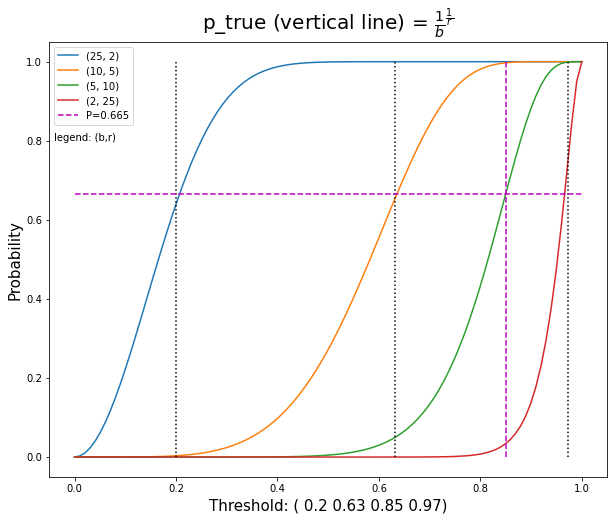

In [ ]:
n = 50
ops = [(25,2), (10,5), (5,10), (2,25)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
yval(pts,.2,.2)
plt.figure(figsize=(10,8))

threshold = []
for op in ops:
    plt.plot(pts, yval(pts,op[1],op[0]), label=op)
    threshold.append(round(np.power((1/op[0]), (1/op[1])), 2))
    
thresholds = ""
for value in threshold:
    thresholds = " ".join([thresholds, str(value)])
    
plt.plot([np.power((1/ops[0][0]), (1/ops[0][1])), np.power((1/ops[0][0]), (1/ops[0][1]))],[0,1], 'k:')    
plt.plot([np.power((1/ops[1][0]), (1/ops[1][1])), np.power((1/ops[1][0]), (1/ops[1][1]))],[0,1], 'k:')
plt.plot([np.power((1/ops[2][0]), (1/ops[2][1])), np.power((1/ops[2][0]), (1/ops[2][1]))],[0,1], 'm--')
plt.plot([np.power((1/ops[3][0]), (1/ops[3][1])), np.power((1/ops[3][0]), (1/ops[3][1]))],[0,1], 'k:')
plt.plot(pts,0*pts+0.665,'m--', label="P=0.665")
plt.legend()
plt.xlabel(f"Threshold: ({thresholds})", fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title(r'p_true (vertical line) = $\frac{1}{b}^{\frac{1}{r}}$', fontsize=20)
plt.text(-0.04, 0.8, r'legend: (b,r)')
plt.show()


We can notice that there are this four possibilities with our number of elements of a signature (50). We've decided to pick a strong similarity between users, so we've chosen $b = 5$ and $r = 10$ to have 85% score as a threshold.

In [ ]:
'''Function to create hash tables and also display as a DataFrame:
first we set the same seed placed in the function to create signatures,
then divide signature matrix in bands that allow to compute an hash value for each subvector of a column.
We create a dictionary of hashing values which will be the hash table for each band for both dataframes(dataset and query).
The keys are indexes represent the bands while the values are lists. 
For each user we'll have a ID's number to rpresent its bucket
Return dataframes to display and a dict with bands and values useful for next steps'''

def hash_func(df, n_bands):
    
    random.seed(1234)
    subvec = df.shape[0] // n_bands
    hash_rows = defaultdict(list)

    for i in range(0, df.shape[0], subvec): 
# for each band, pick randomly prime coefficients for element in those rows by doing dot product module a large prime number
        prime_values = random.sample(primes_range, subvec)
        hash_values = []
        for col in tqdm(df.columns):
            hash_comb = 0
            for j in range(subvec):
                hash_comb += df[col][i+j] * prime_values[j]
            hash_values.append(hash_comb % (69697))
        hash_rows[i//10] = hash_values
    
    hash_table = pd.DataFrame.from_dict(hash_rows).transpose().reset_index(drop=True)
    

    return hash_table, hash_rows

In [ ]:
hash_table_data, bands = hash_func(signature_matrix_data, 5)

100%|██████████| 985322/985322 [01:20<00:00, 12310.34it/s]


In [ ]:
hash_table_query, bands_query = hash_func(signature_matrix_query, 5)

100%|██████████| 46/46 [00:00<00:00, 7687.38it/s]


###### Save files

In [ ]:
hash_table_data.to_pickle('./FILE PKL/hash_table_data.pkl')

In [ ]:
hash_table_query.to_pickle('./FILE PKL/hash_table_query.pkl')

In [ ]:
hash_table_data = pd.read_pickle('./FILE PKL/hash_table_data.pkl')

In [ ]:
hash_table_query = pd.read_pickle('./FILE PKL/hash_table_query.pkl')

In [ ]:
with open('./FILE PKL/bands_data.pkl', 'wb') as f:
    pickle.dump(bands, f)

In [ ]:
with open('./FILE PKL/bands_query.pkl', 'wb') as f:
    pickle.dump(bands_query, f)

In [ ]:
with open('./FILE PKL/bands_data.pkl', 'rb') as f:
    bands = pickle.load(f)

In [ ]:
with open('./FILE PKL/bands_query.pkl', 'rb') as f:
    bands_query = pickle.load(f)

In [ ]:
hash_table_data

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,16742,9406,15107,8743,6527,5810,6309,7671,13018,14380,...,8843,15152,9807,23897,12090,9807,9660,22154,13997,13612
1,13295,11820,13803,9639,16408,21502,12553,14086,13887,9243,...,22168,19455,21868,22590,29234,21868,27099,14318,22949,19728
2,7990,7524,7139,7526,8956,9036,10086,7753,5713,4806,...,9836,8491,5971,5458,8883,5971,9038,5541,3551,5288
3,7020,11671,8874,12176,18522,8080,9300,6904,16830,12399,...,26528,25578,24130,17299,21173,24130,26687,27422,21831,19576
4,9789,19279,7071,8344,9011,15347,10821,15041,8384,12890,...,9876,12265,9104,15049,9086,9104,9896,9622,15042,13821


In [ ]:
hash_table_query

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,8901,9018,7506,6768,13534,10736,12576,14204,12572,12515,...,22674,20557,8358,12602,9152,19121,4275,15971,12483,9737
1,10359,14870,19392,11220,23850,14501,12683,15383,11341,16215,...,20189,12577,20156,23032,23276,10057,14599,17622,12361,19481
2,4491,5185,8768,6885,5568,5535,5862,5055,5451,5115,...,5372,4980,5674,7972,9168,11065,5595,5563,3532,3953
3,9706,10892,21769,18143,6672,10096,14853,16005,20209,12174,...,16970,15254,11526,21388,7701,14441,17186,18076,20063,21485
4,12316,14678,3760,7975,8994,8720,7582,15483,10689,9145,...,8049,10212,8615,10472,14735,7898,15613,5870,10717,13288


**1. increasing r ->** moves the curve right, more false negatives, means lower chance to match

**2. increasing b ->** moves the curve left, more false positives, means higher chance to match

It's time to store the buckets for both dataframes to prepare structures to match similar users 

In [ ]:
'''Function to create buckets of the dataset:
we create a dictionary of hashing values from the hash table above through bands.
The keys represent the bands while
the value is an other dict with hash value of the bucket and set of users associated as a key,value pair'''

def Buckets(dict_bands):
    
    dict_buckets = defaultdict(dict)
    
    for band in tqdm(dict_bands.keys()):
        for j in range(len(dict_bands[band])):
            hash_key = dict_bands[band][j]
            if hash_key in dict_buckets[band].keys():
                dict_buckets[band][hash_key].add(j)
            else:
                dict_buckets[band][hash_key] = {j}
                
    return dict_buckets

In [ ]:
'''Function to create buckets of query:
we create a dictionary of hashing values from the hash table above through query_bands.
The keys represent the bands while
the value is an other dict with query_users as keys and hash value of the bucket as values'''

def q_buckets(bands_query):
    
    dict_buckets_q = defaultdict(dict)
    
    for band in tqdm(bands_query.keys()):
        for hash_key in bands_query[band]:
            user = bands_query[band].index(hash_key)
            if user in dict_buckets_q[band].keys():
                dict_buckets_q[band][user].add(hash_key)
            else:
                dict_buckets_q[band][user] = {hash_key}
                
    return dict_buckets_q

In [ ]:
buckets_dict = Buckets(bands)

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


In [ ]:
query_buckets_dict = q_buckets(bands_query)

100%|██████████| 5/5 [00:00<00:00, 3715.06it/s]


## 1.3 Locality Sensitive Hashing

Last step is to find  what users of the dataset are similar to those of the query file given.

We know that two users are a candidate pair if they go into the same bucket for at least one band which we've created from the signature matrix: remember these are not really similar users but only candidates. We'll use our threshold score to extracxt the users similar to those of the query  from them.

In [ ]:
'''Function LSH:
it retrieves our candidates of similarity for each query in each band.
We create a dictionary of our candidates, the keys represent bands while the values are an other dict 
where at each query are associated candidates that have the same hash value (are in the same bucket)'''

def LSH(dict_buckets, dict_buckets_q):
    
    candidates = defaultdict(dict)
    
    for band in tqdm(dict_buckets_q.keys()):
        for user in dict_buckets_q[band]:
            hash_bucket = dict_buckets_q[band][user].pop()
            if hash_bucket in dict_buckets[band].keys():
                candidates[band][user] = dict_buckets[band][hash_bucket]
    
    return candidates

In [ ]:
candidates = LSH(new_dict, dict_q)

100%|██████████| 5/5 [00:00<00:00, 19364.28it/s]


Now our threshold comes into play, our decision of how much similarity we want among users. 

So we calculate the Jaccard similarity for each (query, candidate) pair in each band. Remember that the signature vector will give us an approximation of the true Jaccard, in fact  we'll lower a bit the score and we'll have few more false positives that we'll remove after. 

In [ ]:
'''Function to calculate the Jaccard similarity between signature vectors of the candidates retrieved previously'''

def Jaccard_sim(query, candidate, sign_data, sign_query):
    
    # intersection of elements by dividing of the union
    inters = len(set(sign_data[candidate]).intersection(set(sign_query[query])))
    union = len(set(sign_data[candidate]).union(set(sign_query[query])))
    jaccard = round((inters/union), 2)
    
    return jaccard


'''Function to retrieve similar users of each query:
we create a dictionary with query as a key and a list of tuples as values.
Each tuple is a pair of the user similar to the query and score associated'''

def match_users(candidates, sign_data, sign_query):
    
    simil_users = defaultdict(list) 
    
    for band in tqdm(candidates.keys()):
        for query in candidates[band].keys():
            for candidate in candidates[band][query]:
                # compute Jaccard between query and candidates from signature matrices
                score = Jaccard_sim(query, candidate, sign_data, sign_query)
                if score >= 0.80:
                    # we want at least this similarity
                    simil_users[query].append((candidate,score))

    for key in simil_users.keys():
        #remove duplicates
        simil_users[key] = list(dict.fromkeys(simil_users[key])) 
        
    
    return simil_users

In [ ]:
simil_users = match_users(candidates, signature_matrix_data, signature_matrix_query)

100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


In [ ]:
'''Function to count how many values two series have in common'''

def check_series(series_1, series_2):
    equal_values = 0
    for i in range(len(series_1)):
        if series_1[i] == series_2[i]:
            equal_values += 1
            
    return equal_values

'''Function to remove false positives according to the threshold chosen that means in the original datasets
we have 5 or 6 same values for all features maintaining the same previously structure of simil_users'''

def check_users(simil_users, data, query_df):
    
    for query in tqdm(simil_users.keys()):
        for user in simil_users[query]:
            # remove all users that are less than 5 values equal to the query in the original datsets
            if (check_series(data.loc[user[0]], query_df.loc[query]) < 5):
                simil_users[query].remove(user)
        # sorting similar users in descending order through its socre
        simil_users[query] = sorted(simil_users[query], key = lambda x: x[1], reverse = True)
    
    return simil_users 

In [ ]:
final_users = check_users(simil_users, final_data, final_query)

100%|██████████| 40/40 [00:00<00:00, 97.75it/s]


In [ ]:
'''Function to retrieve the top 5 similar users for each query:
Create a final dictionary where we'll have all queries as keys and a list of the top 5 similar users as values'''

def retrieve_top_users(similars, data):
    
    top_users = defaultdict(list)
    
    for query in similars.keys(): 
        for item in similars[query]:
            # remove the score, so pick only the item of similar customers
            top_users[query].append(item[0])
        if len(top_users[query]) >= 5:
            # pick the top 5 users 
            top_users[query] = top_users[query][:5]
    
    return top_users   

In [ ]:
top_users = retrieve_top_users(final_users, final_data)

In [ ]:
top_users

defaultdict(list,
            {0: [686641, 682785, 64396, 682438, 62411],
             2: [890625, 891570],
             3: [592413, 593999, 602611, 157272, 773748],
             5: [879010, 883356, 277718, 271595, 881504],
             7: [71706, 696919, 698975, 696132, 74054],
             8: [13345, 563436, 572850],
             9: [546582, 547486, 544601],
             11: [886435, 887639, 276216, 278527, 930234],
             12: [539192, 553852, 552439, 762039, 138457],
             14: [873035, 298915, 878880, 299141, 264846],
             16: [688339, 689058],
             17: [54314, 50340, 52975, 927318, 924340],
             20: [284091, 283113, 289438, 304178, 290764],
             24: [31311, 26794, 604944, 580399, 378372],
             25: [799880, 158883, 179496, 787152, 786319],
             26: [824315, 823966, 209962, 210143, 825574],
             27: [833208, 833754, 227588, 828709, 827780],
             28: [775574, 771229, 760883, 768220, 160227],
             29: 

Finally these are top similar users for each query. We choose three queries to show its most similar users.

In [ ]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [ ]:
display('final_query.iloc[[3]]', 'final_data.iloc[[592413, 593999, 602611, 157272, 773748]]', 
        'final_query.iloc[[17]]', 'final_data.iloc[[54314, 50340, 52975, 927318, 924340]]',
        'final_query.iloc[[38]]', 'final_data.iloc[[236050, 246032, 923547, 235788, 853998]]')

,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction
3,140,77,2065,29,14,1070
,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction
592413,140,77,2065,29,14,1070
593999,140,77,2065,29,13,1070
602611,140,77,2065,29,13,1070
157272,140,77,2065,4,14,1070
773748,140,77,2065,4,14,1070
,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction
17,140,77,2020,3,20,1060
,CustomerAge,CustGender,CustAccountBalance,DayTransaction,HourTransaction,AmountTransaction


## 2 - Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

### 2.1 Getting your data + feature engineering

1) Data access and cleaning

In [ ]:
banks=pd.read_csv(r"C:\Users\simon\Downloads\bank_transactions.csv\bank_transactions.csv", sep=",")

In [ ]:
banks.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [ ]:
banks.shape

(1048567, 9)

The variables we have in the dataset are:

- TransactionID --> unique transaction ID

- CustomerID --> customer ID 

- CustomerDOB --> customer Date Of Birth 

- CustGender --> customer gender

- CustLocation --> where the customer live (?)

- CustAccountBalance --> amount of money present in a financial repository.

- TransactionDate --> date of the transaction

- TransactionTime --> time of the transaction expressed in hour/min/sec(?)

- TransactionAmount (INR) --> transaction amount calculated in indian currency (Indian Rupee)

In [ ]:
banks.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)

Let's explore the dataset further to see if there is anything to adjust.

In [ ]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   TransactionID       1048567 non-null  object 
 1   CustomerID          1048567 non-null  object 
 2   CustomerDOB         1045170 non-null  object 
 3   CustGender          1047467 non-null  object 
 4   CustLocation        1048416 non-null  object 
 5   CustAccountBalance  1046198 non-null  float64
 6   TransactionDate     1048567 non-null  object 
 7   TransactionTime     1048567 non-null  int64  
 8   TransactionAmount   1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


We convert variables CustomerDOB, TransactionDate, TransactionTime to datetime type.

In [ ]:
banks.CustomerDOB = pd.to_datetime(banks["CustomerDOB"], format='%d/%m/%y',errors='coerce')
banks.TransactionDate = pd.to_datetime(banks["TransactionDate"], format='%d/%m/%y',errors='coerce')

In [ ]:
banks.TransactionTime = banks.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Handling missing values.

In [ ]:
banks.isnull().sum()

TransactionID             0
CustomerID                0
CustomerDOB           60736
CustGender             1100
CustLocation            151
CustAccountBalance     2369
TransactionDate           0
TransactionTime           0
TransactionAmount         0
dtype: int64

In [ ]:
banks.dropna(inplace = True)

In [ ]:
banks.isnull().sum()

TransactionID         0
CustomerID            0
CustomerDOB           0
CustGender            0
CustLocation          0
CustAccountBalance    0
TransactionDate       0
TransactionTime       0
TransactionAmount     0
dtype: int64

In [ ]:
banks.shape

(985322, 9)

Another problem we encounter is that there are people who turn out to have been born after 2016.

Also, it is very strange that there are people under 16 years old who go to the bank to make transactions: so let's see how we can fix it. 

Initially, the variable "CustomerDOB" has the following distribution:

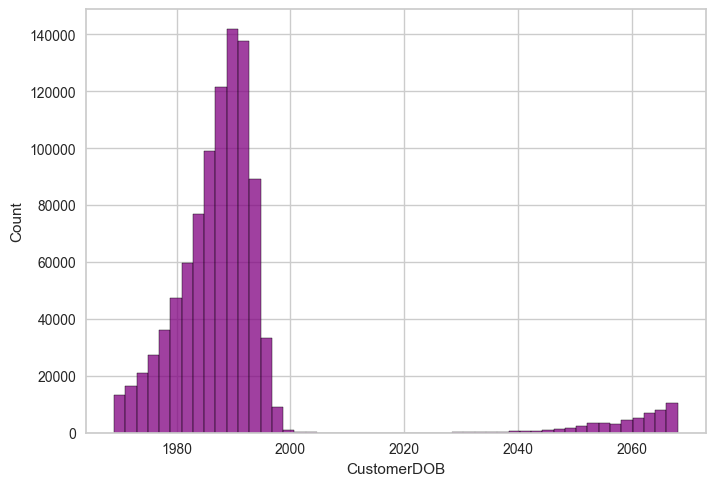

In [ ]:
sns.histplot(banks.CustomerDOB.dt.year,bins=50,color="purple")
plt.show()

The other problem was people born after 2000: for all these people we remove 100 years from the year of birth that appears in the dataset.

In [ ]:
banks.loc[banks.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = banks.loc[banks.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

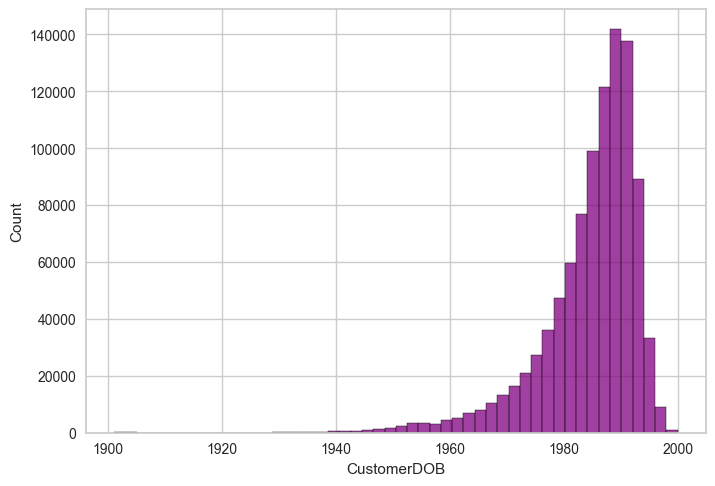

In [ ]:
sns.histplot(banks.CustomerDOB.dt.year,bins=50, color="purple")
plt.show()

Last problem: this distribution also shows people born before 1920 (in 2016 they would be 96 years old and older) but since they are only 632 they should not affect the subsequent analysis too much so we leave the distribution as it is. 

In [ ]:
banks.CustomerDOB.dt.year[banks.CustomerDOB.dt.year<=1920].count()

632

Another problem: there are some transactions with amount of 0. They should be deleted because a transaction was recorded in which there was no movement of money. 

In [ ]:
banks[banks['TransactionAmount'] == 0].count()

TransactionID         708
CustomerID            708
CustomerDOB           708
CustGender            708
CustLocation          708
CustAccountBalance    708
TransactionDate       708
TransactionTime       708
TransactionAmount     708
dtype: int64

In [ ]:
banks = banks.drop(banks[banks['TransactionAmount'] == 0].index,axis = 0)

Now that the dataset is clean and correct we can work with it.

The original dataset has several transactions done by the same customer: group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId.

2) Create new variables.

In [ ]:
# We create an empty dataframe and add new variables to it as we go. 
banks2=pd.DataFrame()

a) Number of transactions

In [ ]:
banks2["num_transaction"] = banks.groupby(['CustomerID'])['TransactionID'].count()

b) Number of transactions with a balance bigger than 100 USD

Since we need to consider the transaction amount expressed in dollars to count the number of transactions with a transaction amount > 100, let us create a new variable in the dataset in which we have all the amounts in the transaction amount column converted to dollars. 

The INR-USD exchange rate is 0.012.

In [ ]:
banks["TransactionAmountUSD"]=banks["TransactionAmount"]*0.012

In [ ]:
banks2["trans_bigger_100"]=banks[banks["TransactionAmountUSD"]>100].groupby(["CustomerID"])["TransactionAmountUSD"].count()

In [ ]:
# Since not all users will have transactions greater than 100USD, we replace NA with 0.
banks2['trans_bigger_100'] = banks2['trans_bigger_100'].fillna(0)
banks2['trans_bigger_100'] = banks2['trans_bigger_100'].astype(int)

c) Average amount of the transactions

In [ ]:
banks2["avg_amount_transaction"] = banks.groupby(['CustomerID'])['TransactionAmount'].mean()

d) Average balance

In [ ]:
banks2["avg_balance"] = banks.groupby(['CustomerID'])['CustAccountBalance'].mean()

e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

In [ ]:
avg_utilisation=banks2.avg_balance-banks2.avg_amount_transaction

In [ ]:
banks2['avg_utilisation'] = avg_utilisation

f) Most common gender of the customer

In general, we take the most frequent sex.
The problem arises when there are two modes (for a single ID there are two transactions, one made by a man and one made by a woman): to solve we take the first value that is returned. 

In [ ]:
 # we select the mode
gender = banks.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode)

In [ ]:
# For those observations that have more than one mode we take the first value that appears. 
for i in gender.index:
    gender[i]=gender[i][0]

In [ ]:
banks2["gender"]=gender

h) Most frequent location of the customer

In [ ]:
# we select the mode
location = banks.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)

In [ ]:
# For those observations that have more than one mode we take the first value that appears.
lista_citta=[]
for i in location.index:
    if type(location.loc[i])==str:
        lista_citta.append(location[i])
    else:
        lista_citta.append(location[i][0])

In [ ]:
banks2["location"]=lista_citta

Just as a matter of convenience, we also directly add the CustomerID variable so that we can work with it when needed.

In [ ]:
banks2["customer_id"]=np.sort(list(set(banks.CustomerID)))

Let's see how our datase appears

In [ ]:
banks2.head()

,num_transaction,trans_bigger_100,avg_amount_transaction,avg_balance,avg_utilisation,gender,location,customer_id
CustomerID,,,,,,,,
C1010011,2,0,2553.0,76340.635,73787.635,F,NEW DELHI,C1010011
C1010012,1,0,1499.0,24204.490,22705.490,M,MUMBAI,C1010012
C1010014,2,0,727.5,100112.950,99385.450,F,MUMBAI,C1010014
C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,C1010018
C1010024,1,0,5000.0,87058.650,82058.650,M,KOLKATA,C1010024


3) Let's generate 20 features more to add to our dataset.

We know that each customerID is valid for different people. What we want to know is the maximum age and the minimum age of the people who made payment with a given customerID. 

We begin by creating the CustomerAge column in the original dataset.

In [ ]:
banks['CustomerAge'] = 2016 - banks.CustomerDOB.dt.year

1) max_age (with respect to 2016)

In [ ]:
banks2["max_age"] = banks.groupby('CustomerID')['CustomerAge'].max()

2) min_age (with respect to 2016)

In [ ]:
banks2["min_age"] = banks.groupby('CustomerID')['CustomerAge'].min()

We calculated the average amount of each transaction. We are also going to study the maximum and minimum.

3) max_amount_transaction

In [ ]:
banks2["max_amount_transaction"] = banks.groupby(['CustomerID'])['TransactionAmount'].max()

4) min_amount_transaction

In [ ]:
banks2["min_amount_transaction"] = banks.groupby(['CustomerID'])['TransactionAmount'].min()

We also studied the average balance.
What we want to do now is to study the maximum and minimum balance.

5) max_account_balance

In [ ]:
banks2["max_account_balance"] = banks.groupby(['CustomerID'])['CustAccountBalance'].max()

6) min_account_balance

In [ ]:
banks2["min_account_balance"] = banks.groupby(['CustomerID'])['CustAccountBalance'].min()

We created a variable to see the number of transactions above 100USD. 

However, since we have the transactions expressed in Indian currency, it might be interesting to study the number of transactions greater than a certain threshold also in terms of INR, to identify, for example, who is spending more. 

7) Number of transaction with TransactionAmount > 10000(INR)

In [ ]:
banks2["trans_bigger_10000"]=banks[banks["TransactionAmount"]>10000].groupby(["CustomerID"])["TransactionAmount"].count()

In [ ]:
banks2['trans_bigger_10000'] = banks2['trans_bigger_10000'].fillna(0)
banks2['trans_bigger_10000'] = banks2['trans_bigger_10000'].astype(int)

7) Number of transaction with TransactionAmount > 100000 (INR)

In [ ]:
banks2["trans_bigger_100000"]=banks[banks["TransactionAmount"]>100000].groupby(["CustomerID"])["TransactionAmount"].count()

In [ ]:
banks2['trans_bigger_100000'] = banks2['trans_bigger_100000'].fillna(0)
banks2['trans_bigger_100000'] = banks2['trans_bigger_100000'].astype(int)

What we are interested in knowing now is the most common day and, more importantly, month in which a transaction is made by each Customer.

In [ ]:
banks['TransactionMonth'] = banks['TransactionDate'].dt.month
banks['TransactionDay'] = banks['TransactionDate'].dt.dayofweek

In [ ]:
banks['TransactionDay'] =  banks['TransactionDay'].astype(str)

In [ ]:
banks['TransactionMonth'] =  banks['TransactionMonth'].astype(str)

8) most_common_day

In [ ]:
most_common_day = banks.groupby(['CustomerID'])['TransactionDay'].agg(pd.Series.mode)

In [ ]:
lista_giorni=[]
for i in most_common_day.index:
    if type(most_common_day.loc[i])==str:
        lista_giorni.append(most_common_day[i])
    else:
        lista_giorni.append(most_common_day[i][0])

In [ ]:
banks2["most_common_day"]=lista_giorni

9) most_common_month 

In [ ]:
most_common_month= banks.groupby(['CustomerID'])['TransactionMonth'].agg(pd.Series.mode)

In [ ]:
lista_mesi=[]
for i in most_common_month.index:
    if type(most_common_month.loc[i])==str:
        lista_mesi.append(most_common_month[i])
    else:
        lista_mesi.append(most_common_month[i][0])

In [ ]:
banks2["most_common_month"]=lista_mesi

We also want to see the time of day when a Customer is most active.

In [ ]:
moments_of_the_day = []
for i in banks.TransactionTime.dt.hour:
    if i >=6 and i < 13:
        moments_of_the_day.append("Morning")
    elif i >= 13 and i<=17:
        moments_of_the_day.append("Afternoon")
    elif i > 17 and i <= 22:
        moments_of_the_day.append("Evening")
    elif i > 22:
        moments_of_the_day.append("Night")
    elif i < 6:
        moments_of_the_day.append("Night")
banks['transaction_mom_day'] = moments_of_the_day

10) most_common_moment_day

In [ ]:
most_common_moment_day= banks.groupby(['CustomerID'])['transaction_mom_day'].agg(pd.Series.mode)

In [ ]:
lista_momenti=[]
for i in most_common_moment_day.index:
    if type(most_common_moment_day.loc[i])==str:
        lista_momenti.append(most_common_moment_day[i])
    else:
        lista_momenti.append(most_common_moment_day[i][0])

In [ ]:
banks2["most_common_moment_day"]=lista_momenti

Remark: to simplify things in the following analysis, let us recode this variable.

In [ ]:
moments_day_cod={'Morning':1,'Afternoon':2,'Evening':3,'Night':4}

In [ ]:
banks2["most_common_moment_day"]=banks2["most_common_moment_day"].apply(lambda x:moments_day_cod[x])

Another interesting thing to look at is the maximum, minimum and average percentage of what you spend versus what you actually have in your account.

11) avg_transaction_ratio

In [ ]:
banks['TransactionRatio'] = banks['TransactionAmount'] *100 / (banks['CustAccountBalance'])

In [ ]:
banks['TransactionRatio'].replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
banks2["avg_transaction_ratio"]=banks.groupby(['CustomerID'])['TransactionRatio'].mean()

12) max_transaction_ratio

In [ ]:
banks2["max_transaction_ratio"]=banks.groupby(['CustomerID'])['TransactionRatio'].max()

13) min_transaction_ratio

In [ ]:
banks2["min_transaction_ratio"]=banks.groupby(['CustomerID'])['TransactionRatio'].min()

In addition to studying what month, day, or time of day customers have been most active, it might be interesting to look at who are the customers who have transacted recently and who have not transacted for a long time.

Let's look at how many days have passed since the last transaction.

In [ ]:
banks['DaysSinceTransaction'] = (pd.to_datetime('today') - banks['TransactionDate'])/np.timedelta64(1, 'D')

However, we are interested in understanding how many days have passed since the last transaction by taking the year 2016 as a reference, so we rescale our distribution with respect to that year.

In [ ]:
banks['DaysSinceTransaction']= banks['DaysSinceTransaction'] - banks['DaysSinceTransaction'].min()

14) days_since_last_trans 

In [ ]:
banks2["day_since_last_trans"]=banks.groupby(['CustomerID'])['DaysSinceTransaction'].min()

In [ ]:
banks2["day_since_last_trans"]=banks2["day_since_last_trans"].astype(int)

We calculated the average utilisation.

What we are interested in now is looking at the maximum and minimum utilisation to see if a customer ever had a debit or always had a positive balance in the account.

In [ ]:
banks["Utilisation"]=banks.CustAccountBalance-banks.TransactionAmount

15) max_utilisation

In [ ]:
banks2["max_utilisation"]= banks.groupby(['CustomerID'])['Utilisation'].max()

16) min_utilisation

In [ ]:
banks2["min_utilisation"]= banks.groupby(['CustomerID'])['Utilisation'].min()

It might be interesting to see who the richest clients are.
What we will do is to consider the 100 customers with highest average balance and classify them as the richest ones.

17) richest

In [ ]:
balance_dei_100_ricchi=banks2.avg_balance.nlargest(n=100)

In [ ]:
lista=[]
for i in balance_dei_100_ricchi.index:
    lista.append(i)

In [ ]:
lista_ricchi=[]
for i in banks2.customer_id:
    if banks2.customer_id[i] in lista:
        lista_ricchi.append(banks2.customer_id[i])

In [ ]:
banks2.insert(0,"richest", " ")

In [ ]:
for i in banks2.customer_id:
    if banks2.customer_id[i] in lista_ricchi:
        banks2.loc[i,'richest'] = '1'
    else:
        banks2.loc[i,'richest'] = '0'

Last thing you could do is to recalculate in dollars "Average amount of the transactions" , "Average balance" and "Average utilization" of each customer: reporting everything to the value of a known currency will certainly make it easier to interpret the results. 

18) avg_amount_transaction_usd

In [ ]:
banks2["avg_amount_transaction_usd"]=banks2["avg_amount_transaction"]*0.012

19) avg_balance_usd

In [ ]:
banks2["avg_balance_usd"]=banks2["avg_balance"]*0.012

20) avg_utilisation_usd

In [ ]:
banks2["avg_utilisation_usd"]=banks2["avg_utilisation"]*0.012

We code the variables gender and location as it may come in useful later. What we will do is assign an integer number, in ascending order, to each gender/city. 

gender_cod

In [ ]:
def gender_cod(gender):
    dic = {}
    contatore = 1
    for gender in banks2.gender.unique():
        dic[gender]=contatore
        contatore+=1
    return dic

In [ ]:
gender_cod = gender_cod(banks2.gender)

In [ ]:
lista_cod_gender=[]

for i in banks2.gender:
    lista_cod_gender.append(gender_cod[i])

In [ ]:
banks2["gender_cod"]=lista_cod_gender

location_cod

We have 7863 different locations.

In [ ]:
unique_locations = len(np.unique(np.array(banks2.location)))

In [ ]:
def location_cod(location):
    dic = {}
    contatore = 1
    for loc in banks2.location.unique():
        dic[loc]=contatore
        contatore+=1
    return dic

In [ ]:
location_cod = location_cod(banks2.location)

In [ ]:
lista_cod_loc=[]

for i in banks2.location:
    lista_cod_loc.append(location_cod[i])

In [ ]:
banks2["location_cod"]=lista_cod_loc

### 2.2 Choose your features (variables)!

Working a dataset that has 27 variables is a rather complicated thing. In addition, many variables were created as a "linear combination" of others, so we have a lot of redundant information.
What we can do, then, is to reduce the dimensionality of the space using a suitable algorithm: one could use principal component analysis (PCA). 

Obs: in this case we also have qualitative variables in our dataset, which might make it inappropriate to use PCA as a dimensionality reduction method, since it is designed exclusively for continuous quantitative variables. 

So let us go to analyze our dataset to see whether indeed the qualitative variables that cause us "problems" are discriminating for our ultimate goal (grouping similar customers to offer them the same services) or not. 

The qualitative variables we have are:

- richest --> Indicates whether a client is in the top 100 richest or not. It might be a good discriminant variable but it is constructed using the average balance, so we can get the same information just by looking at that variable. 

- most_common_day --> It is not necessary to know the most common day of the week on which a customer transacts. Rather, it is much more important to know how many transactions he makes and of what amount, and these are variables that we have. 

- most_common_month --> Same as for most_common_day

- most_common_moment_day --> Same as for most_common_day and most_common_month

- location_cod --> A bank is based in many different cities: customers in the same city are not necessarily similar. Maybe it may be that there are richer/poorer cities, but to look at the
wealth/poverty of the customer, it is always sufficient to look at the average balance or average utilization; it is not necessary to know where he or she made a transaction. 

- gender_cod --> Being that people of different sexes correspond to the same customerID, considering gender as a discriminating variable does not make much sense. 

Conclusion: we eliminate our qualitative variables, as the information they provide can be safely found by looking at other variables, and let's use PCA.

In [ ]:
banks2_copy = banks2[["num_transaction","trans_bigger_100","avg_amount_transaction","avg_balance","avg_utilisation","max_age","min_age","max_amount_transaction",
"min_amount_transaction","max_account_balance","min_account_balance","trans_bigger_10000","trans_bigger_100000","avg_transaction_ratio", "max_transaction_ratio", "day_since_last_trans","min_transaction_ratio", "max_utilisation", "min_utilisation",
"avg_amount_transaction_usd", "avg_balance_usd", "avg_utilisation_usd"]]

In [ ]:
banks2_copy.head()

,num_transaction,trans_bigger_100,avg_amount_transaction,avg_balance,avg_utilisation,max_age,min_age,max_amount_transaction,min_amount_transaction,max_account_balance,...,trans_bigger_100000,avg_transaction_ratio,max_transaction_ratio,day_since_last_trans,min_transaction_ratio,max_utilisation,min_utilisation,avg_amount_transaction_usd,avg_balance_usd,avg_utilisation_usd
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.0,76340.635,73787.635,33,24,4750.0,356.0,120180.54,...,0,7.455639,14.615056,25,0.296221,119824.54,27750.73,30.636,916.08762,885.45162
C1010012,1,0,1499.0,24204.490,22705.490,22,22,1499.0,1499.0,24204.49,...,0,6.193066,6.193066,68,6.193066,22705.49,22705.49,17.988,290.45388,272.46588
C1010014,2,0,727.5,100112.950,99385.450,32,24,1205.0,250.0,161848.76,...,0,1.647178,3.139890,75,0.154465,161598.76,37172.14,8.730,1201.35540,1192.62540
C1010018,1,0,30.0,496.180,466.180,26,26,30.0,30.0,496.18,...,0,6.046193,6.046193,36,6.046193,466.18,466.18,0.360,5.95416,5.59416
C1010024,1,0,5000.0,87058.650,82058.650,51,51,5000.0,5000.0,87058.65,...,0,5.743255,5.743255,64,5.743255,82058.65,82058.65,60.000,1044.70380,984.70380


Before proceeding with PCA we need to check that there are no outliers in our dataset and that the variables we will include in the analysis are at least partially correlated with each other. 

Step 1: check for outliers.

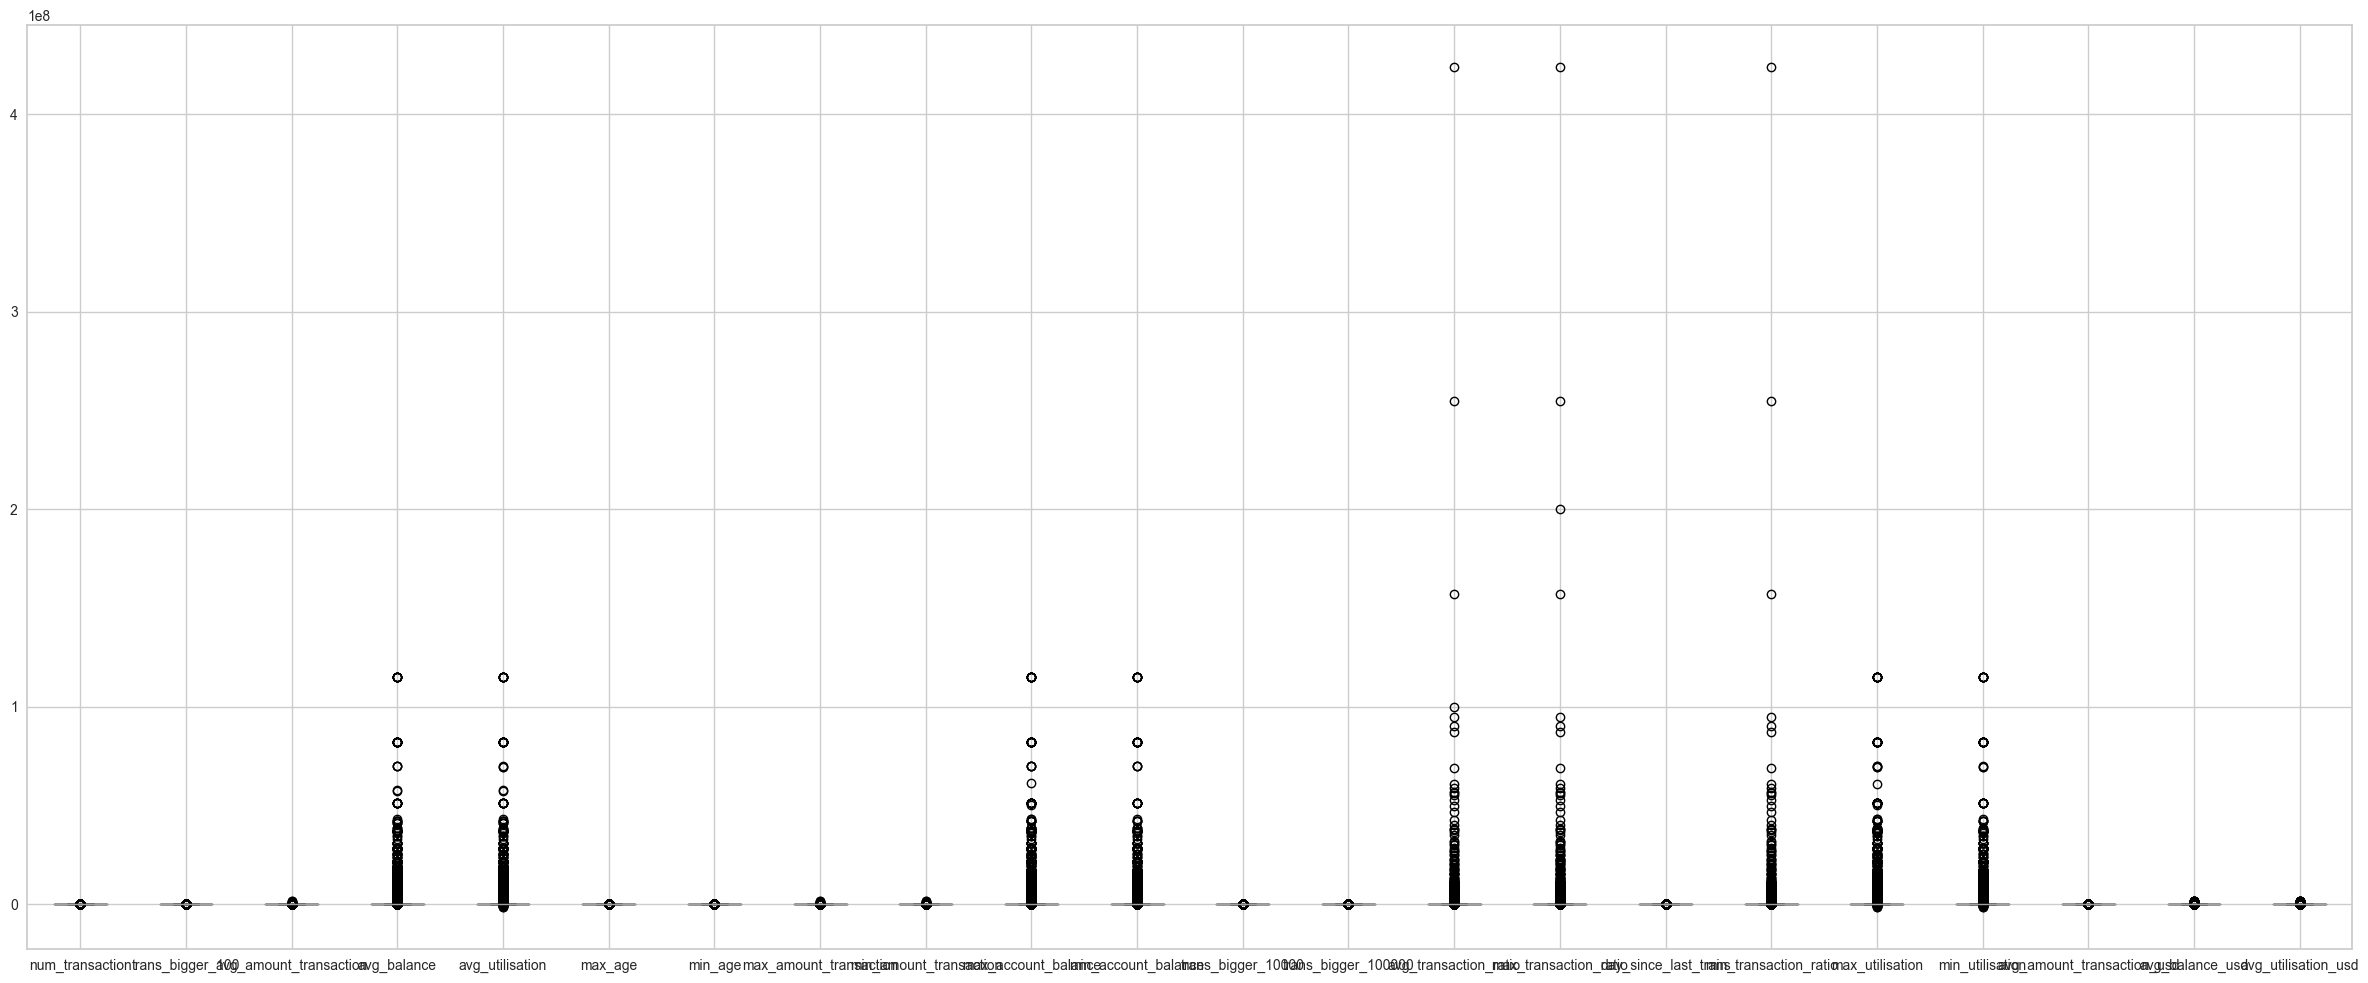

In [ ]:
f, ax = plt.subplots(figsize=(30,12))

warnings.filterwarnings("ignore")
banks2_copy.boxplot();

There are some variables that count a large amount of outliers: to resolve this, we set equal to their median all those observations that are outside the interquartile range. 

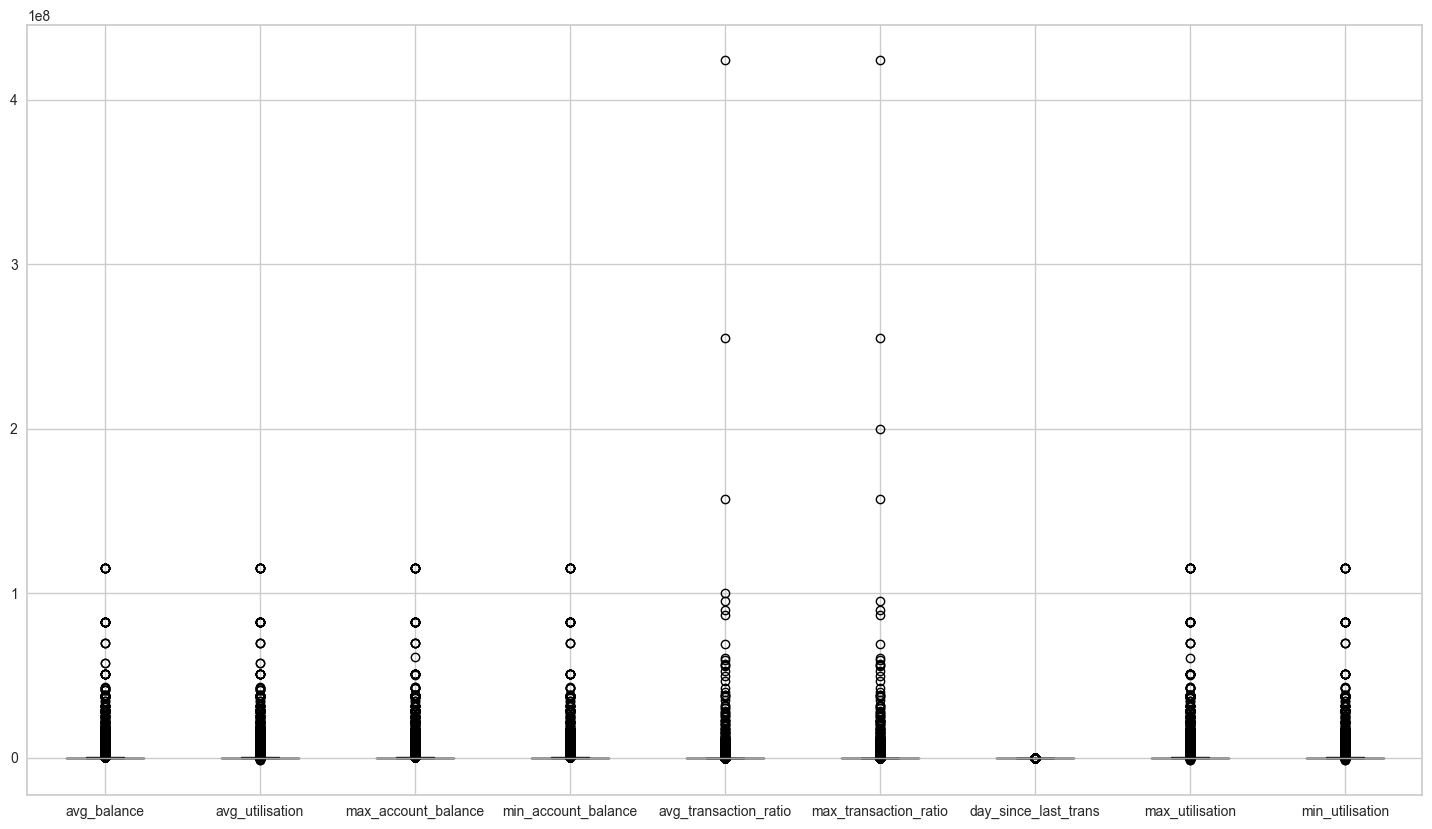

In [ ]:
f, ax = plt.subplots(figsize=(18,10))
warnings.filterwarnings("ignore")
banks2_copy.iloc[:,[3,4,9,10,13,14,15,17,18]].boxplot();

Step 2: We substitute the outliers in each column of the dataframe for the average of the values in that column.

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
# substitute outliers for avg_balance

for x in ['avg_balance']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['avg_balance'] = banks2_copy['avg_balance'].fillna(banks2_copy['avg_balance'].median())

In [ ]:
# substitute outliers for avg_utilisation

for x in ['avg_utilisation']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['avg_utilisation'] = banks2_copy['avg_utilisation'].fillna(banks2_copy['avg_utilisation'].median())

In [ ]:
# substitute outliers for max_account_balance

for x in ['max_account_balance']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan


In [ ]:
banks2_copy['max_account_balance'] = banks2_copy['max_account_balance'].fillna(banks2_copy['max_account_balance'].median())

In [ ]:
# substitute outliers for min_account_balance

for x in ['min_account_balance']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['min_account_balance'] = banks2_copy['min_account_balance'].fillna(banks2_copy['min_account_balance'].median())

In [ ]:
# substitute outliers for avg_transaction_ratio

for x in ['avg_transaction_ratio']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['avg_transaction_ratio'] = banks2_copy['avg_transaction_ratio'].fillna(banks2_copy['avg_transaction_ratio'].median())

In [ ]:
# substitute outliers for max_transaction_ratio

for x in ['max_transaction_ratio']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['max_transaction_ratio'] = banks2_copy['max_transaction_ratio'].fillna(banks2_copy['max_transaction_ratio'].median())

In [ ]:
# substitute outliers for min_transaction_ratio

for x in ['min_transaction_ratio']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['min_transaction_ratio'] = banks2_copy['min_transaction_ratio'].fillna(banks2_copy['min_transaction_ratio'].median())

In [ ]:
# substitute outliers for max_utilisation

for x in ['max_utilisation']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['max_utilisation'] = banks2_copy['max_utilisation'].fillna(banks2_copy['max_utilisation'].median())

In [ ]:
# substitute outliers for avg_balance

for x in ['min_utilisation']:
    q75,q25 = np.percentile(banks2_copy.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    banks2_copy.loc[banks2_copy[x] < min,x] = np.nan
    banks2_copy.loc[banks2_copy[x] > max,x] = np.nan

In [ ]:
banks2_copy['min_utilisation'] = banks2_copy['min_utilisation'].fillna(banks2_copy['min_utilisation'].median())

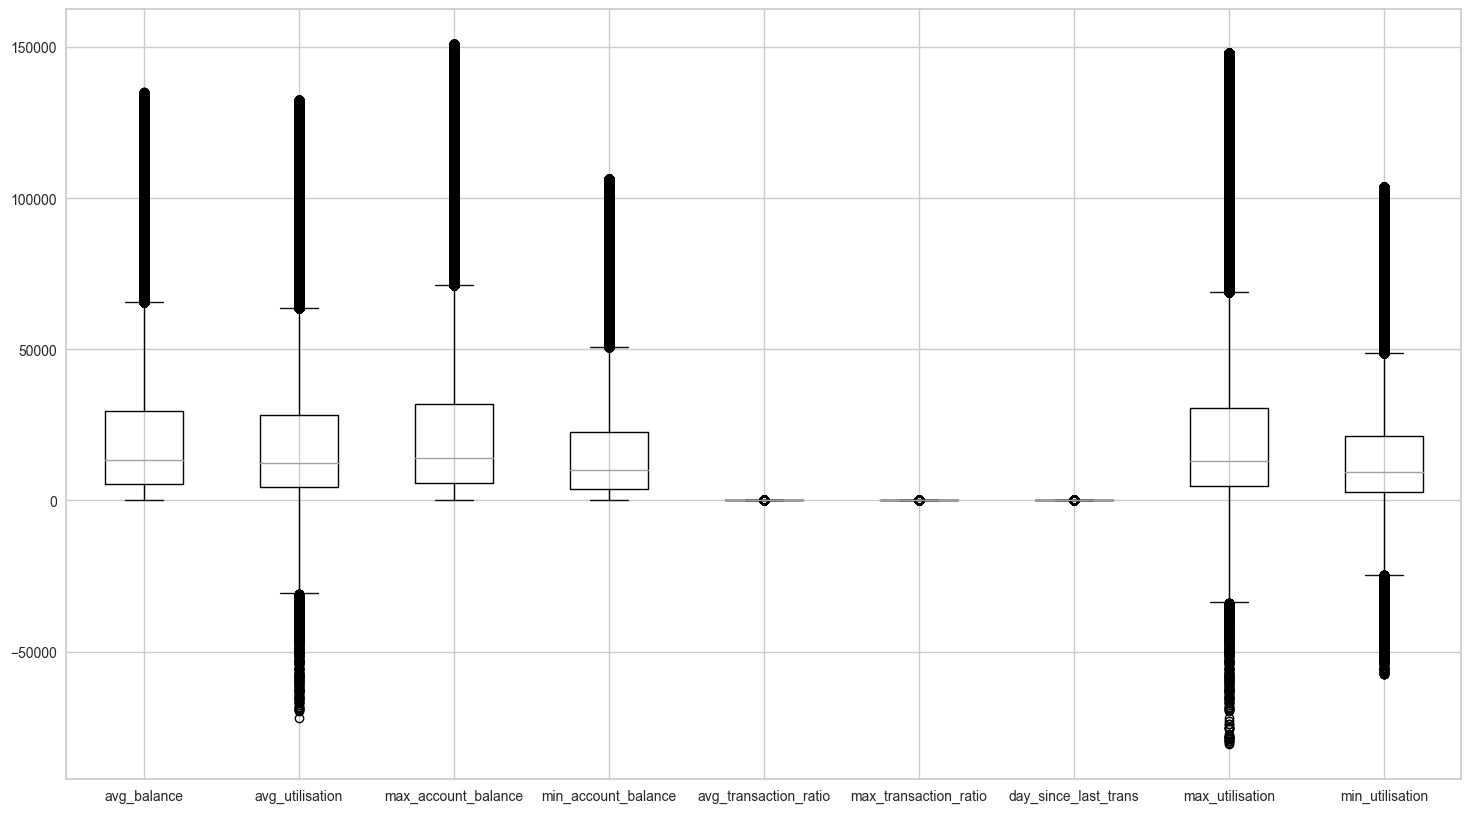

In [ ]:
f, ax = plt.subplots(figsize=(18,10))
warnings.filterwarnings("ignore")
banks2_copy.iloc[:,[3,4,9,10,13,14,15,17,18]].boxplot();

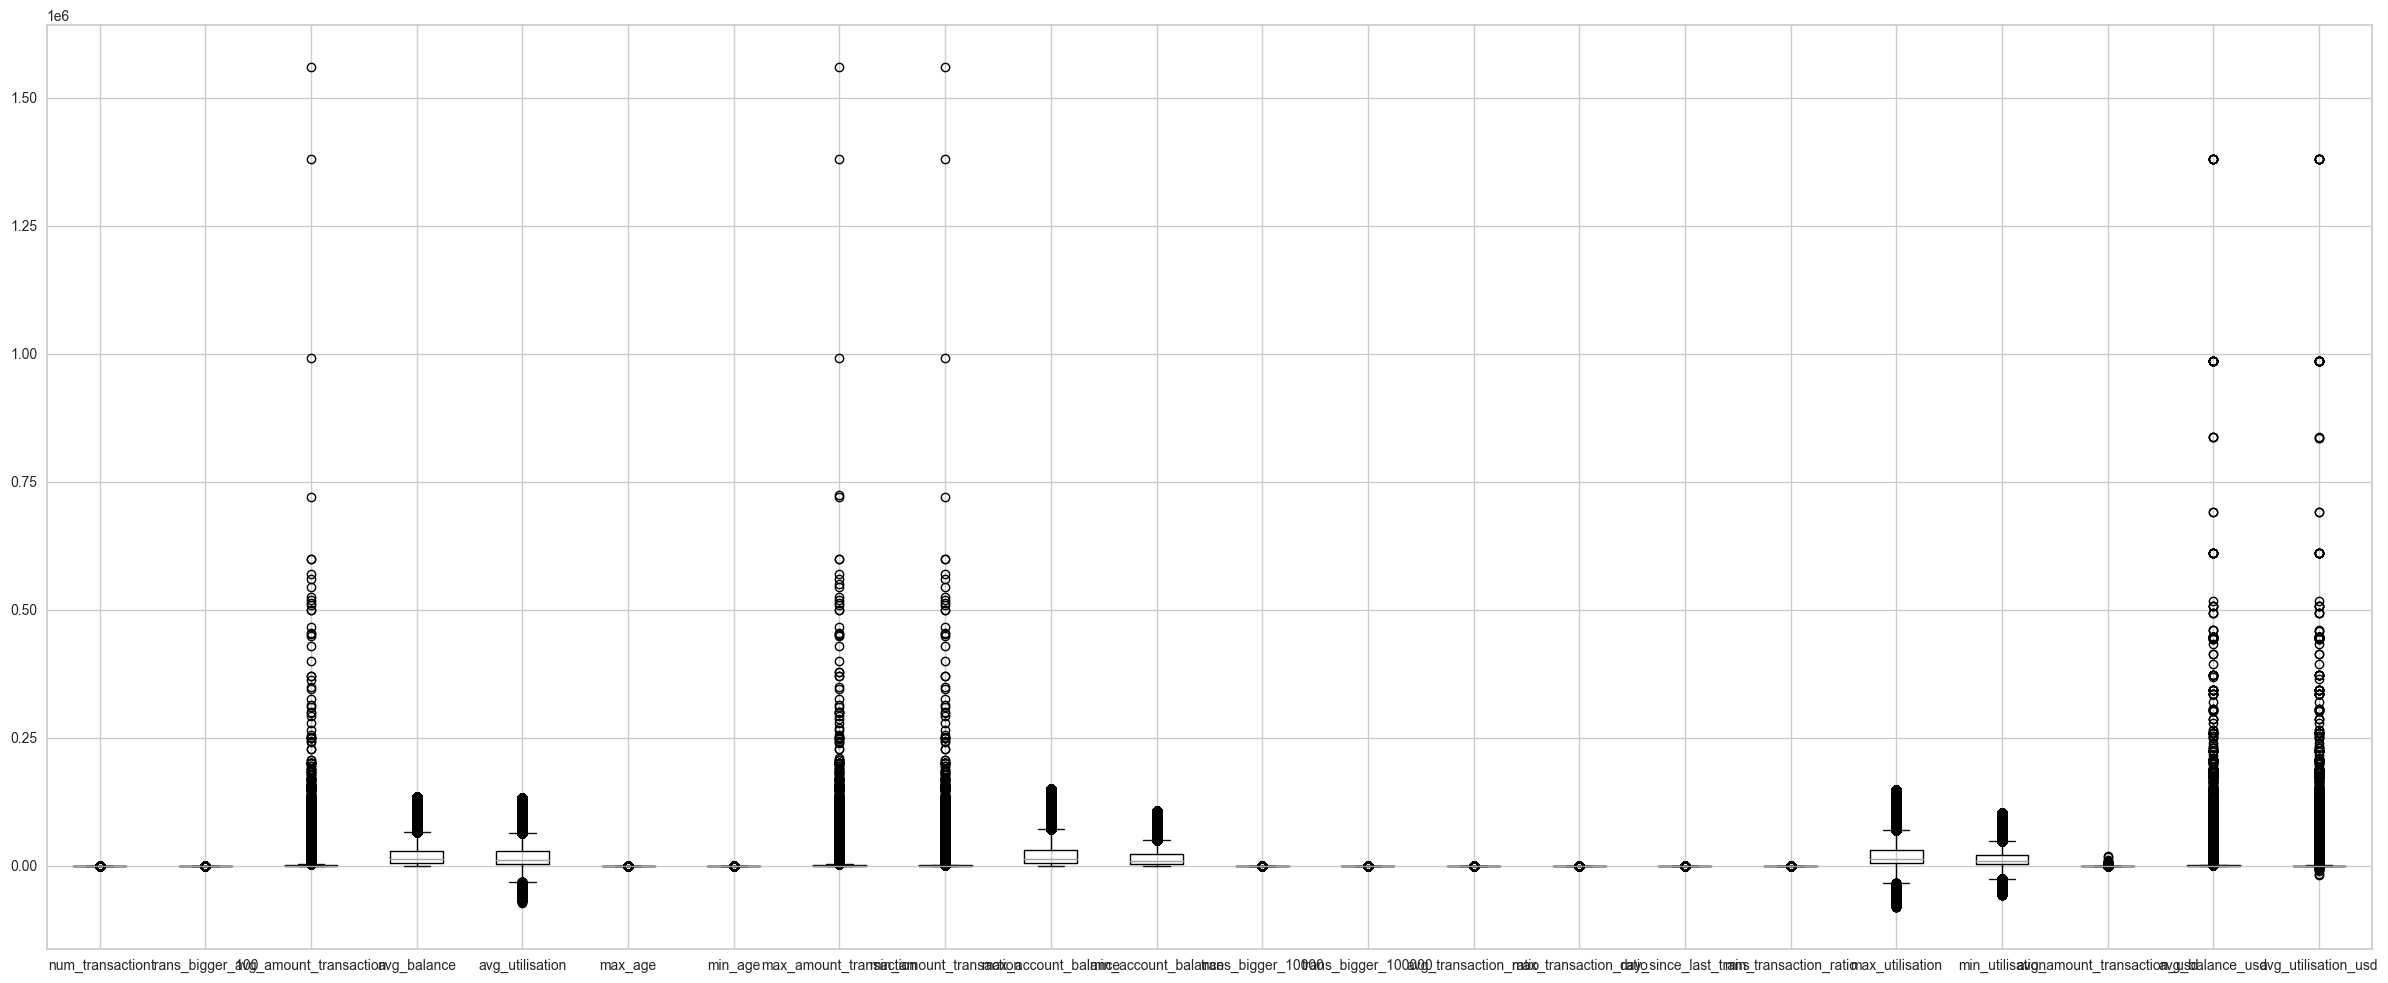

In [ ]:
f, ax = plt.subplots(figsize=(30,12))
warnings.filterwarnings("ignore")
banks2_copy.boxplot();

Step 3: Let's look at the correlations between the variables:

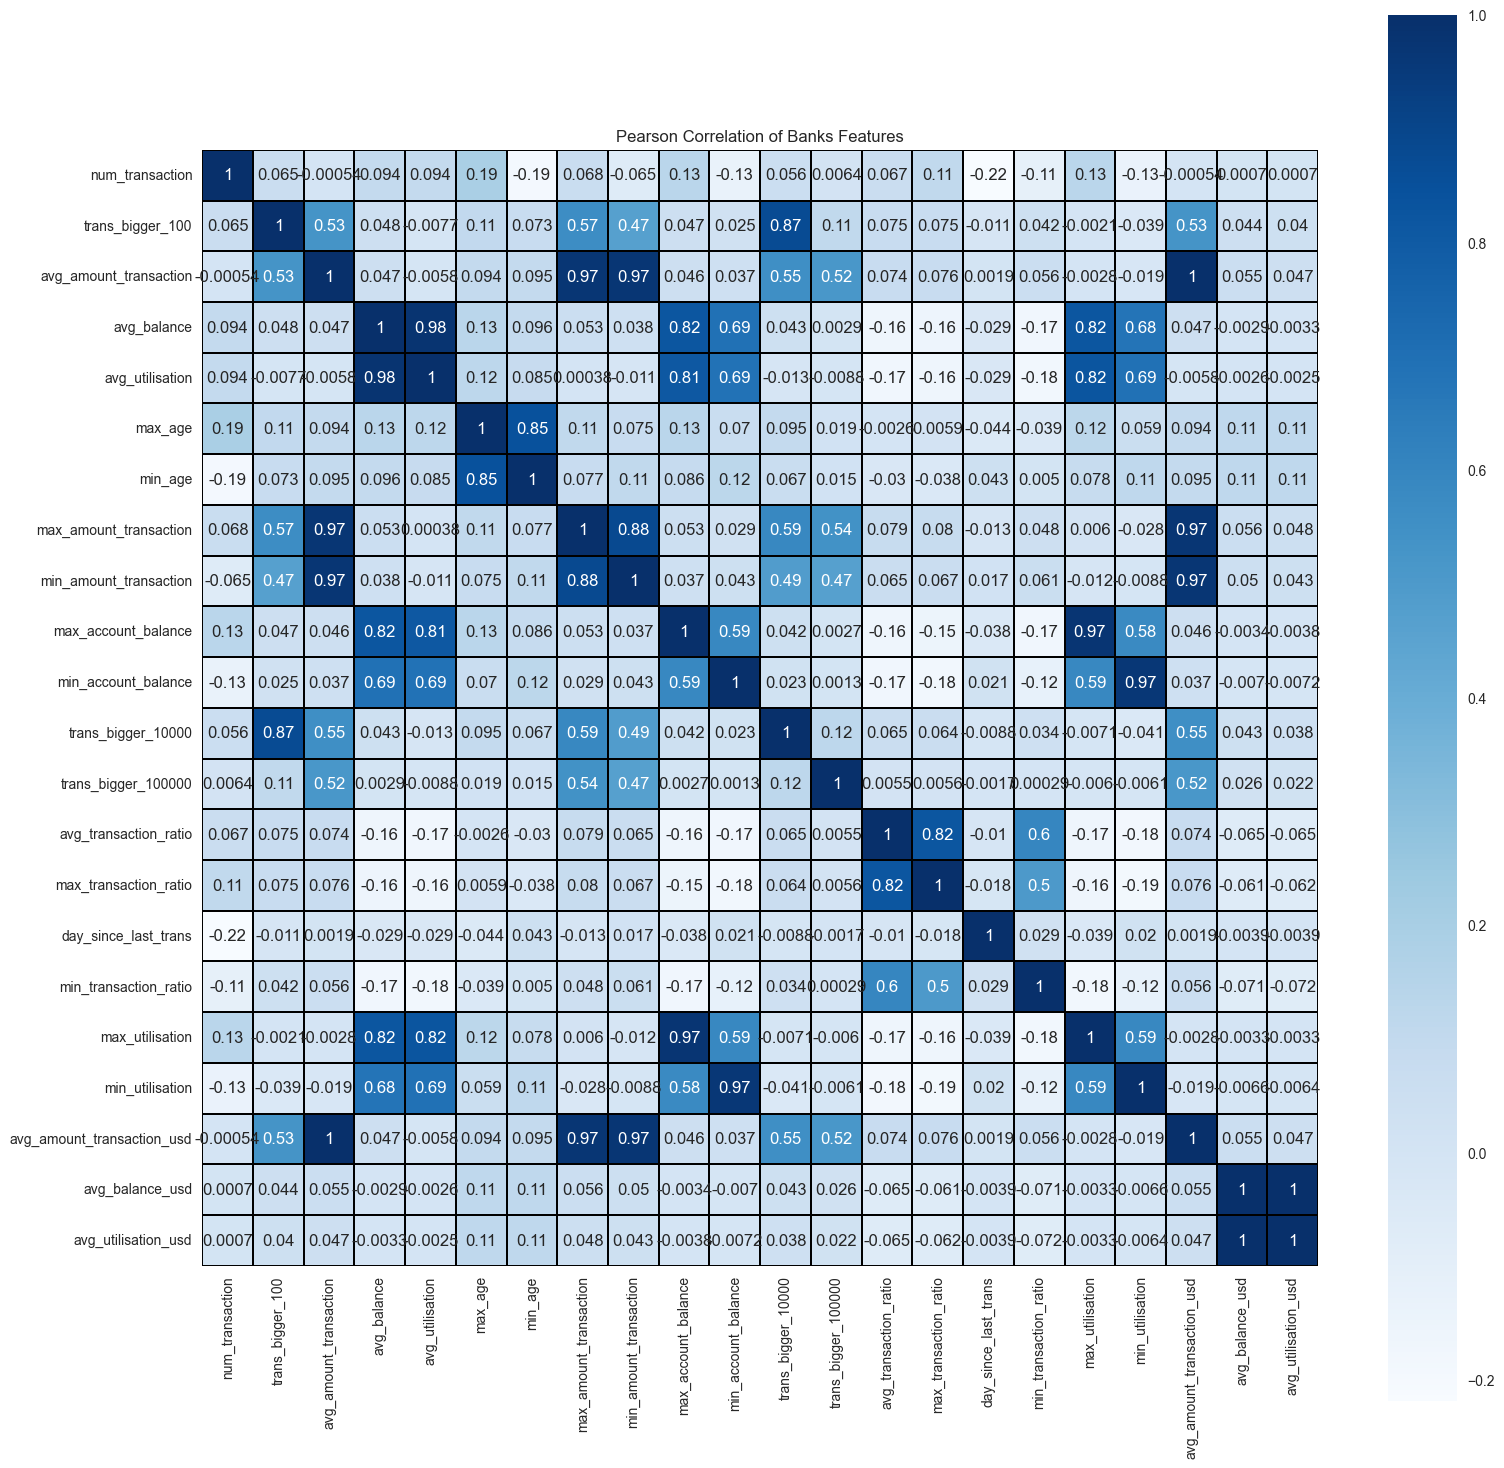

In [ ]:
f, ax = plt.subplots(figsize=(18,18))
plt.title('Pearson Correlation of Banks Features')
sns.heatmap(banks2_copy.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="Blues", linecolor='black', annot=True)
plt.show()

1) Normalize or not Normalize?

Since we will use principal component analysis (PCA) as our dimension reduction method, we need to understand how to treat our variables in order to apply this method. 

Purpose of PCA is to find directions that maximizes the variance. If variance of one variable is higher than others we make the principal components biased in that direction.

So, best thing to do is make the variance of all variables the same. One way of doing this is by standardizing all the variables.

Normalization does not make all variables to have the same variance. 

In conclusion, since in this case we have variables with very different variance (just think of the difference between a variable expressed in dollars and one expressed in INR), what we will do is standardize our variables.

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
banks2_copy.replace({-np.inf: -1_000_000, np.inf: 1_000_000}, inplace=True)

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
banks2_norm = scaler.fit_transform(banks2_copy)

In [ ]:
banks2_norm = pd.DataFrame(banks2_norm, columns = ["num_transaction","trans_bigger_100","avg_amount_transaction","avg_balance","avg_utilisation","max_age","min_age","max_amount_transaction",
"min_amount_transaction","max_account_balance","min_account_balance","trans_bigger_10000","trans_bigger_100000","avg_transaction_ratio", "max_transaction_ratio", "min_transaction_ratio", "day_since_last_trans","max_utilisation", "min_utilisation",
"avg_amount_transaction_usd", "avg_balance_usd", "avg_utilisation_usd"])

In [ ]:
banks2_norm.head()

,num_transaction,trans_bigger_100,avg_amount_transaction,avg_balance,avg_utilisation,max_age,min_age,max_amount_transaction,min_amount_transaction,max_account_balance,...,trans_bigger_100000,avg_transaction_ratio,max_transaction_ratio,min_transaction_ratio,day_since_last_trans,max_utilisation,min_utilisation,avg_amount_transaction_usd,avg_balance_usd,avg_utilisation_usd
0,1.898505,-0.177241,0.181630,1.906757,1.879592,0.125107,-0.740672,0.469415,-0.158160,3.061094,...,-0.018886,0.545509,1.476969,-1.997842,-0.641244,3.132657,0.510637,0.181630,-0.037474,-0.038886
1,-0.400403,-0.177241,0.007331,0.027202,0.017553,-1.056831,-0.973043,-0.020958,0.036021,-0.045406,...,-0.018886,0.334959,0.232121,0.827401,0.772684,-0.053180,0.275921,0.007331,-0.103801,-0.103898
2,1.898505,-0.177241,-0.120251,2.763770,2.812680,0.017658,-0.740672,-0.065305,-0.176168,-0.369518,...,-0.018886,-0.423127,-0.219167,1.287324,-0.675234,-0.364768,0.948941,-0.120251,-0.007231,-0.006308
3,-0.400403,-0.177241,-0.235596,-0.827504,-0.793111,-0.627035,-0.508302,-0.242539,-0.213543,-0.812784,...,-0.018886,0.310466,0.210412,-1.275106,0.737467,-0.782705,-0.758700,-0.235596,-0.133962,-0.132202
4,-0.400403,-0.177241,0.586288,2.293151,2.181086,2.059186,2.396326,0.507125,0.630796,1.989023,...,-0.018886,0.259947,0.165635,0.564587,0.664830,1.893807,3.037159,0.586288,-0.023839,-0.028360


2) Select a method for dimensionality reduction.

As said before, we're going to use PCA.

3) Let's apply PCA to our data --> we consider 5 principal components.

In [ ]:
pca5 = PCA(n_components=5)

In [ ]:
x_5d= pca5.fit_transform(banks2_norm)

In [ ]:
print(pca5.explained_variance_ratio_.cumsum())

[0.23002817 0.45504441 0.55740918 0.64791557 0.72193439]


In [ ]:
print("With 5 principal components we explain:",round((pca5.explained_variance_ratio_.sum())*100,2),"%")

With 5 principal components we explain: 72.19 %


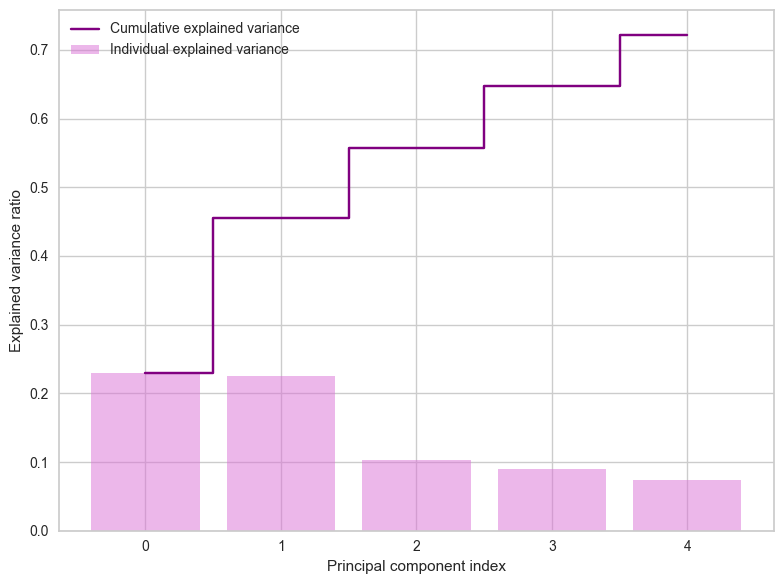

In [ ]:
figure(figsize=(8, 6))

principalDf5 = pd.DataFrame(data = x_5d
             , columns = ['PC1', 'PC2','PC3','PC4','PC5'])

exp_var_pca = pca5.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance', color="orchid")
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance', color= "purple")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
principalDf5.head()

,PC1,PC2,PC3,PC4,PC5
0,3.034556,-2.997546,-1.890116,0.993994,1.587902
1,-0.259573,0.017177,-0.953201,-0.429925,1.101527
2,1.578689,-2.414215,-0.325705,-0.353393,0.737595
3,-1.816619,1.258753,-0.377167,-0.196339,0.420659
4,4.793350,-3.588123,-0.819020,2.374054,-1.691518


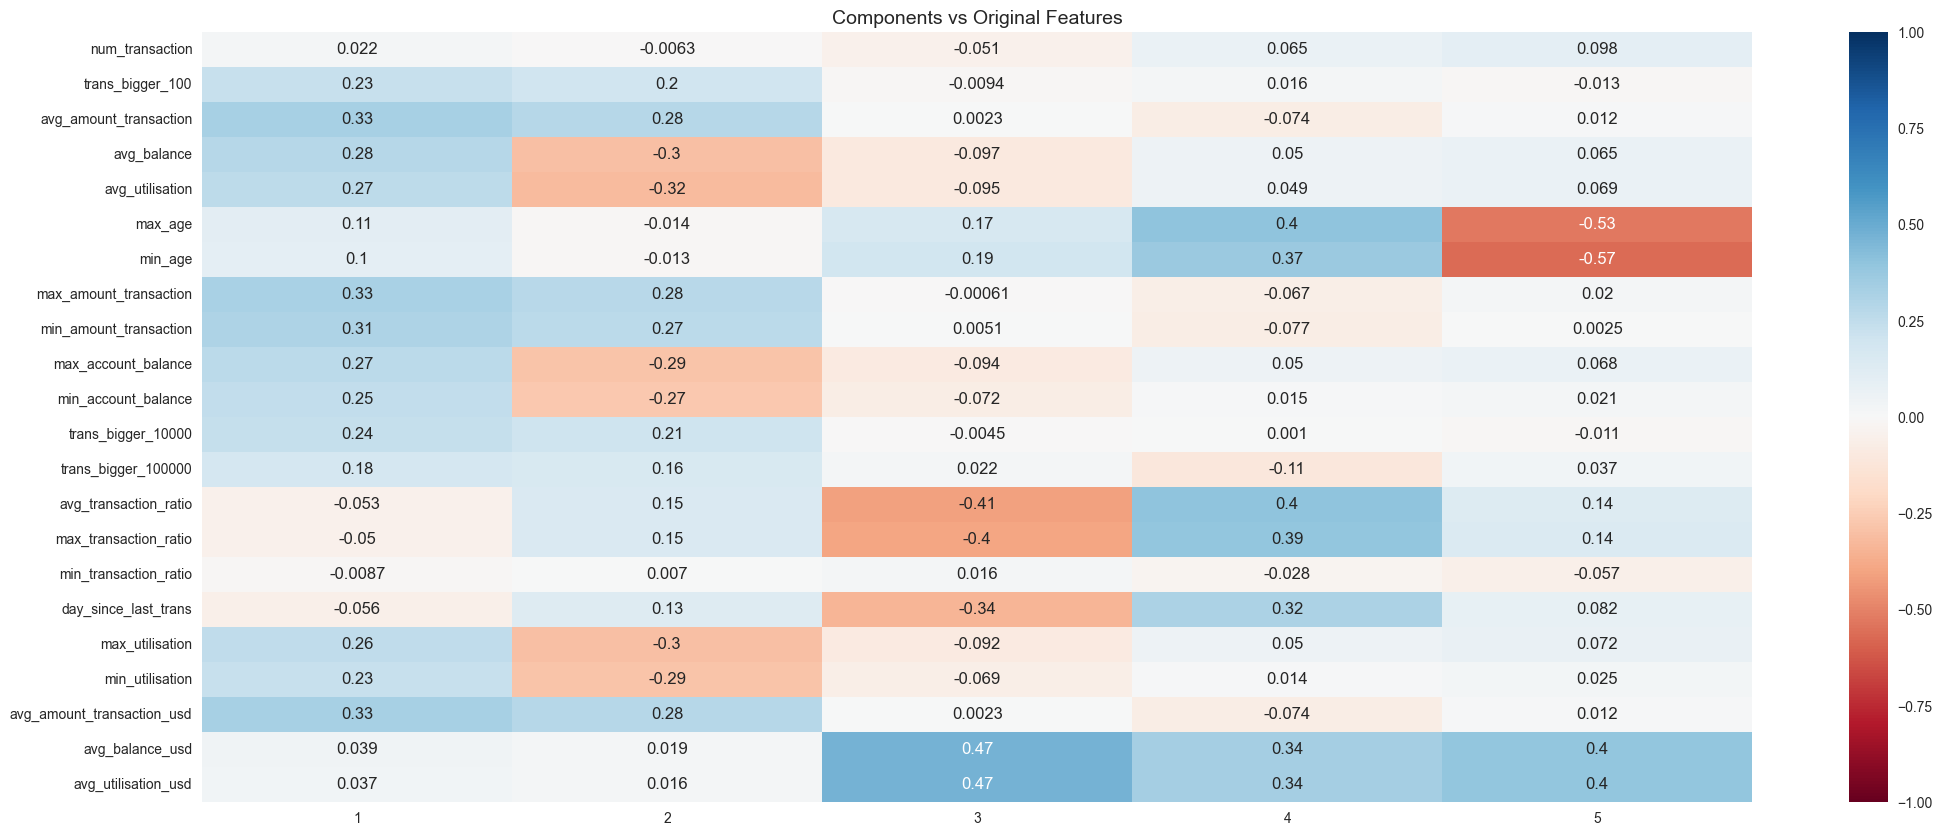

In [ ]:
plt.figure(figsize=(25,10))
x_axis_labels = [1,2,3,4,5] # labels for x-axis
y_axis_labels = ["num_transaction","trans_bigger_100","avg_amount_transaction","avg_balance","avg_utilisation","max_age","min_age","max_amount_transaction",
"min_amount_transaction","max_account_balance","min_account_balance","trans_bigger_10000","trans_bigger_100000","avg_transaction_ratio", "max_transaction_ratio", "min_transaction_ratio","day_since_last_trans", "max_utilisation", "min_utilisation",
"avg_amount_transaction_usd", "avg_balance_usd", "avg_utilisation_usd"]
ax = sns.heatmap(pca5.components_.T,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels
            )
            
plt.yticks(rotation='horizontal')
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

### 2.3 Clustering!

1) Implement the K-means clustering algorithm.

K-Means is actually one of the simplest unsupervised clustering algorithm. Assume we have input data points x1,x2,x3,…,xn and value of K(the number of clusters needed). We follow the below procedure:

1) Pick K points as the initial centroids from the data set, either randomly or the first K.

2) Find the Euclidean distance of each point in the data set with the identified K points — cluster centroids.

3) Assign each data point to the closest centroid using the distance found in the previous step.

4) Find the new centroid by taking the average of the points in each cluster group.

5) Repeat 2 to 4 for a fixed number of iteration or till the centroids don’t change.

We will give as input the number of clusters (chosen according to the elbow method) and the dataframe we constructed once we did the PCA, and the algorithm will classify each observation into the appropriate cluster.

In [ ]:
# kmeans without MapReduce

def kmeans_scratch(k, ds):
    
    # STEP 0: We have to select the values to cluster: if we have a dataframe as input we use the appropriate command;
    #  if we have a list of values we take as a vector "values" all the input passed.

    if isinstance(ds, pd.DataFrame):
      values = ds.values # Creating a values array with the values inside ds
    else:
      values = ds
    
    m = values.shape[1] # Columns
    n = values.shape[0] # Rows
    
    # STEP 1: Now we need to initialize the matrix of centroids (with dimension (n*k).
    # In the first step, centroids are randomly selected from the previously created list of values in our dataset.

    centroids = values[np.random.choice(n, size = k, replace=False)]

    # STEP 1.1: The centroids will update at each iteration so we need to create a vector where we save the centroids of the i-th iteration. 
    
    centroids_i = np.zeros((n,k))
    
    # STEP 2: We need to iterate. We initialize the number of iterations to 0.

    it = 0 

    # Oss: We need to set conditions under which the algorithm can proceed with iteration.
    # Specifically, our loop will stop if the centroids do not change in two successive iterations or if the number of iterations exceeds 10. 

    while it != 20 or np.array_equal(centroids, centroids_i) == False:

        centroids_i = centroids # Centroids for the next iteration
        EuclideanDistance = np.zeros((n,k)) # Euclidean distance matrix
        clusters_dict = defaultdict(list) # Clusters collected into a dict    
        clusters = [] # Identified cluster 
        
        # STEP 4: We initialize the distance matrix so that we can update the centroids each time based on the calculated Euclidean distances. 
        for i in range(n):
            for j in range(k):
                EuclideanDistance[i][j] += np.linalg.norm(values[i]-centroids[j])

            # STEP 5: We assign each value in the dataset a cluster such that the distance to that cluster is minimum.
            clusters.append(np.where(EuclideanDistance[i] == np.min(EuclideanDistance[i]))[0][0]+1)
            
            # STEP 5.1: Let's save this information in a dictionary.
            clusters_dict[clusters[i]].append(i)
        
        # STEP 6: We update the centroid that identifies each with the average of the values in that cluster 
        # (which obviously updates with each iteration).
        for a in range(k):
            for j in range(m):
                my_values = []
                for i in clusters_dict[a+1]: # Clusters' labels are 1, 2, ..., K
                    # Take the values of the observation belonging to the i-th cluster
                    my_values.append(values[i][j])
                # New centroids for each cluster 
                centroids[a][j] = np.mean(my_values)
        it += 1
    return clusters

We have used the Spark framework for the implementation of $K$- Means via MapReduce. It can be found in the additional notebook `MapReduce_KMeans.ipynb`. Its results are reported together with the ones of $K$- Means from scratch later in paragraph 2.3 - 3.

2) Find an optimal number of clusters.

First method: Elbow method --> suggests using 8 clusters.

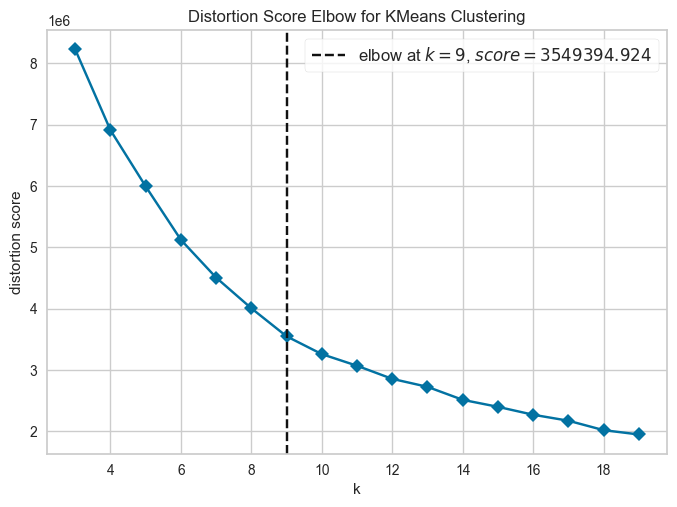

In [ ]:
warnings.filterwarnings("ignore")
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), timings=False)
visualizer.fit(principalDf5)
visualizer.show();

Second method: Calinski-Harabasz index.

The optimal number of clusters corresponds to the solution with the highest Calinski-Harabasz index value.

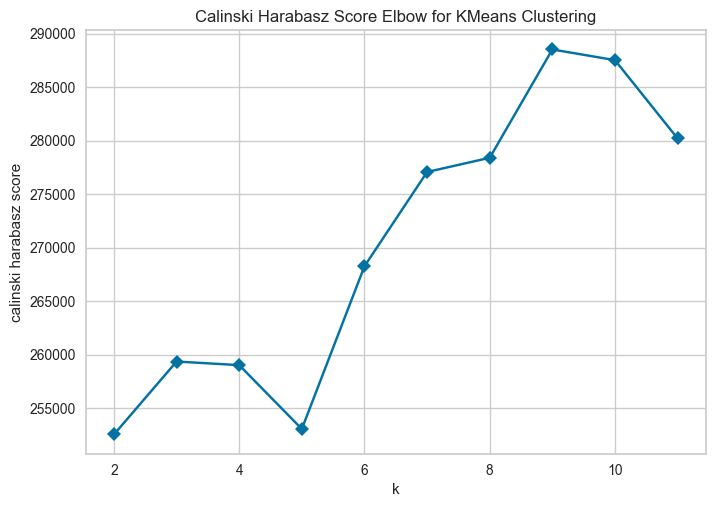

In [ ]:
warnings.filterwarnings("ignore")
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False, locate_elbow=False) 
visualizer.fit(principalDf5)
visualizer.show();

In conclusion, we will consider 9 clusters.

3) Run the algorithm on the data.

In [ ]:
# Let's make a copy of our dataset 
principalDf5_mykmeans=principalDf5.copy()

In [ ]:
%%time

principalDf5_mykmeans["clusters_mykmeans"]=kmeans_scratch(9,principalDf5)

CPU times: total: 8min 51s
Wall time: 9min 45s


In [ ]:
principalDf5_mykmeans.head()

,PC1,PC2,PC3,PC4,PC5,clusters_mykmeans
0,3.034556,-2.997546,-1.890116,0.993994,1.587902,7
1,-0.259573,0.017177,-0.953201,-0.429925,1.101527,2
2,1.578689,-2.414215,-0.325705,-0.353393,0.737595,4
3,-1.816619,1.258753,-0.377167,-0.196339,0.420659,2
4,4.793350,-3.588123,-0.819020,2.374054,-1.691518,6


In [ ]:
principalDf5_mykmeans["clusters_mykmeans"].value_counts()

1    338811
4    139454
2    100266
8     78422
7     71590
9     66933
6     25087
3     17880
5       118
Name: clusters_mykmeans, dtype: int64

We choose to represent two and three dimensions graphically because they are the ones that explain the most variance.

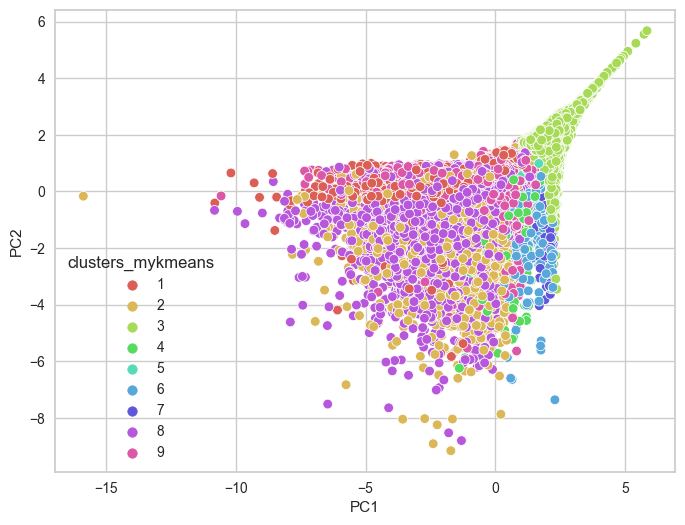

In [ ]:
# 2D graph
plt.figure(figsize=(8,6))

warnings.filterwarnings("ignore")

unique_values = len(principalDf5_mykmeans.clusters_mykmeans.unique())

sns.scatterplot(x= np.log(principalDf5_mykmeans.PC1), 
                y= np.log(principalDf5_mykmeans.PC2),
                palette=sns.color_palette('hls', unique_values),
                hue= principalDf5_mykmeans.clusters_mykmeans);

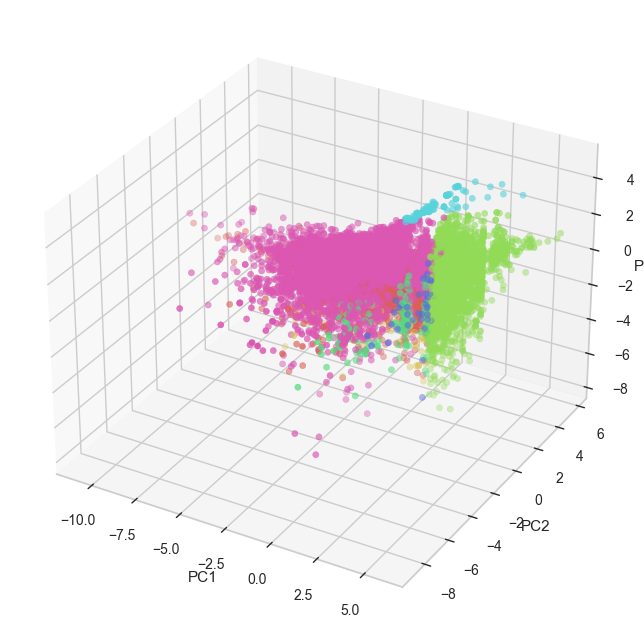

In [ ]:
# 3D graph 
plt.figure(figsize=(10,8))

warnings.filterwarnings("ignore")
unique_values = len(principalDf5_mykmeans.clusters_mykmeans.unique())

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(principalDf5_mykmeans.PC1), np.log(principalDf5_mykmeans.PC2), np.log(principalDf5_mykmeans.PC3), 
           c = principalDf5_mykmeans.clusters_mykmeans,
           cmap = sns.color_palette('hls', unique_values, as_cmap=True))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

Now we run the algorithm implementation with MapReduce on the same data and report its results. As we used a different environment for the execution, we simply load the results from the files they've been saved to here to provide an insight:

In [ ]:
principalDf5_mykmeans_mapred = pd.read_csv("files/mapreduce_keymeans.csv", sep = ',')

In [ ]:
principalDf5_mykmeans_mapred.dropna(inplace = True)
principalDf5_mykmeans_mapred['cluster'] = principalDf5_mykmeans_mapred['cluster'].astype(np.int64)

In [ ]:
principalDf5_mykmeans_mapred.head()

,PC1,PC2,PC3,PC4,PC5,cluster
0,3.034556,-2.997546,-1.890116,0.993994,1.587901,0
1,-0.259573,0.017177,-0.953201,-0.429925,1.101527,5
2,1.578689,-2.414215,-0.325705,-0.353393,0.737595,1
3,-1.816619,1.258753,-0.377167,-0.196339,0.420659,6
4,4.793350,-3.588123,-0.819019,2.374054,-1.691518,0


In [ ]:
principalDf5_mykmeans_mapred['cluster'].value_counts()

6    280461
5    124413
3    115460
7    113380
1     89061
0     64552
8     28759
2     17644
4       118
Name: cluster, dtype: int64

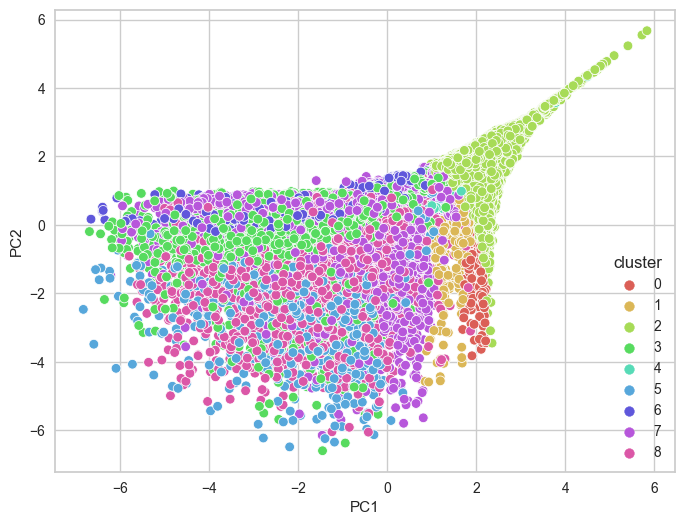

In [ ]:
# 2D graph
plt.figure(figsize=(8,6))
unique_values = len(principalDf5_mykmeans_mapred["cluster"].unique())

warnings.filterwarnings("ignore")
sns.scatterplot(x = np.log(principalDf5_mykmeans_mapred.PC1), 
                y = np.log(principalDf5_mykmeans_mapred.PC2),
                palette = sns.color_palette('hls', unique_values),
                hue = principalDf5_mykmeans_mapred["cluster"]);

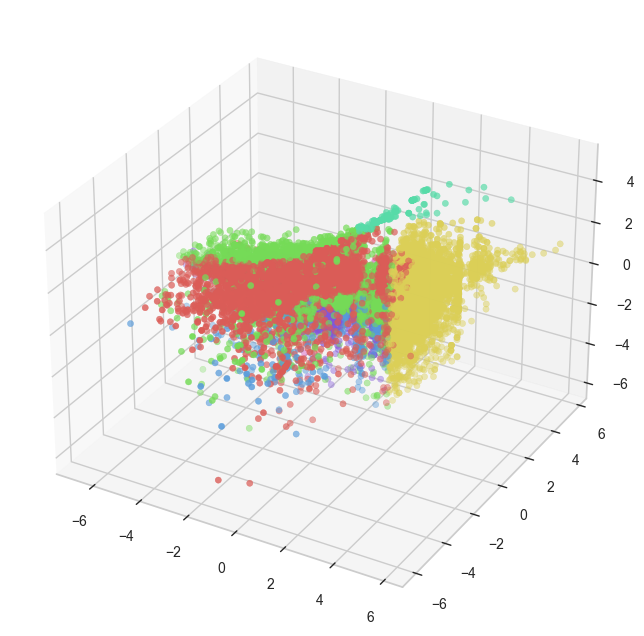

In [ ]:
# 3D graph
plt.figure(figsize=(10,8))
fig = plt.figure(1)
warnings.filterwarnings("ignore")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(principalDf5_mykmeans_mapred.PC1), np.log(principalDf5_mykmeans_mapred.PC2), np.log(principalDf5_mykmeans_mapred.PC3), 
           c = principalDf5_mykmeans_mapred.cluster,
           cmap = sns.color_palette('hls', unique_values, as_cmap = True))
plt.show()

4) Use the already implemented version of K-means++

In [ ]:
principalDf5_kmeans=principalDf5.copy()

In [ ]:
%%time

kmeans = KMeans(n_clusters=9, init='k-means++')   # Number of clusters == 9
kmeans = kmeans.fit(principalDf5_kmeans)          # Fitting the input data
labels = kmeans.predict(principalDf5_kmeans)      # Getting the cluster labels
centroids = kmeans.cluster_centers_ 

CPU times: total: 15.1 s
Wall time: 4.71 s


In [ ]:
principalDf5_kmeans["cluster_kmeans++"]=labels

In [ ]:
principalDf5_kmeans.head()

,PC1,PC2,PC3,PC4,PC5,cluster_kmeans++
0,3.034556,-2.997546,-1.890116,0.993994,1.587902,5
1,-0.259573,0.017177,-0.953201,-0.429925,1.101527,0
2,1.578689,-2.414215,-0.325705,-0.353393,0.737595,1
3,-1.816619,1.258753,-0.377167,-0.196339,0.420659,0
4,4.793350,-3.588123,-0.819020,2.374054,-1.691518,5


In [ ]:
principalDf5_kmeans["cluster_kmeans++"].value_counts() 

0    389922
1    147936
2    116340
5     84060
6     80446
3     18849
4       862
7       117
8        29
Name: cluster_kmeans++, dtype: int64

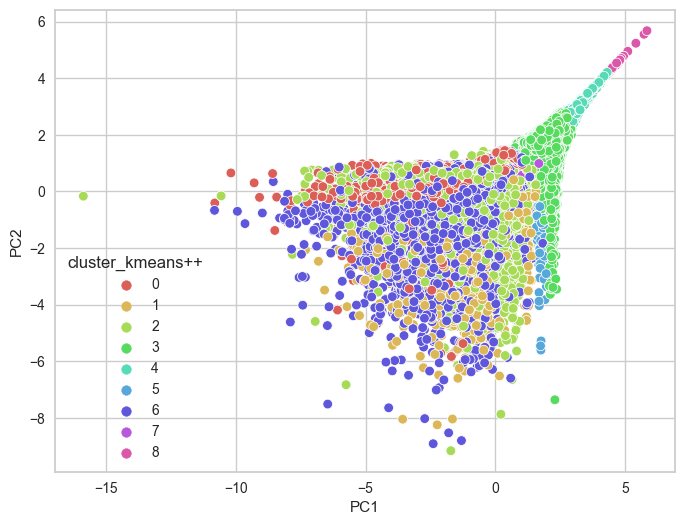

In [ ]:
# 2D graph 
plt.figure(figsize=(8,6))

unique_values = len(principalDf5_kmeans["cluster_kmeans++"].unique())

warnings.filterwarnings("ignore")

sns.scatterplot(x= np.log(principalDf5_kmeans.PC1), 
                y= np.log(principalDf5_kmeans.PC2),
                palette=sns.color_palette('hls', unique_values),
                hue= principalDf5_kmeans["cluster_kmeans++"]);

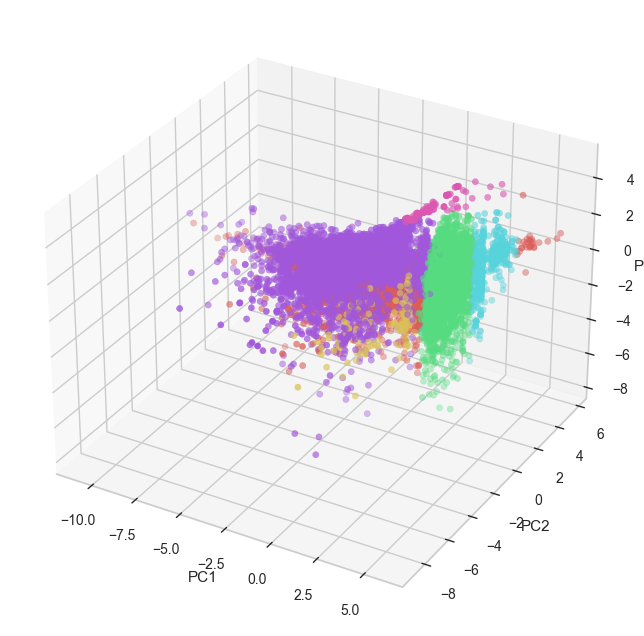

In [ ]:
# 3D graph
plt.figure(figsize=(10,8))

unique_values = len(principalDf5_kmeans["cluster_kmeans++"].unique())

warnings.filterwarnings("ignore")

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(principalDf5_kmeans.PC1), np.log(principalDf5_kmeans.PC2), np.log(principalDf5_kmeans.PC3), 
           c = principalDf5_kmeans["cluster_kmeans++"],
           cmap = sns.color_palette('hls', unique_values, as_cmap=True))

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

The main difference between the two algorithms lies in the choice of centroids.

In the kmeans implemented by us the centroids are chosen randomly and updated each iteration, while in kmeans++, in the initial step, those points that best represent the entire distribution in space are initialized as centroids. 

### 2.4 Analysing your results!

1) Select 2-3 variables you think are relevant to identify the cluster of the customer.

We will use the following variables: avg_utilisation, avg_transaction_ratio, avg_amounut_transaction.

Three variables were chosen that indicate, some more and some less, the attitude that customers have in dealing with their money. 

Since the bank has to offer similar services to similar customers, grouping people who have the same thinking in handling money (those who tend to spend more, those who are more inclined to safeguard their savings, etc...) might be a good strategy.   


2) Categorize our variables into four classes. In particular, we will use the quartiles of the distribution of each variable to define the classes.  

3) Perform pivot tables (On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable).

4) Calculate the percentage by column for each pivot table.

5) Interpret the results for each pivot table.

In [ ]:
banks2_cluster=banks2_copy.copy()

In [ ]:
# We add the cluster column to our original dataset so that we can build pivot tables there more easily.
banks2_cluster["cluster"]=labels

In [ ]:
# We need to divide the values of the considered variable into 4 categories --> we choose to divide the distribution into quartiles.
quantiles1=np.quantile(banks2_copy['avg_utilisation'],q=[0,0.25,0.5,0.75,1])
banks2_cluster['avg_utilisation'] = pd.cut(banks2_copy['avg_utilisation'], quantiles1)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format 
cols_1 = ['avg_utilisation', 'cluster']

pivot_1 = banks2_cluster[cols_1]

pivot_1 = pd.pivot_table(data=pivot_1, 
                        index=banks2_cluster['avg_utilisation'], 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot_1 = round(pivot_1 / pivot_1.sum() * 100, 2)

pivot_1

avg_utilisation                                      \
cluster                             0     1     2     3     4     5     6   
avg_utilisation                                                             
(-71865.68, 4568.33]            35.60  0.00 44.61 28.74 27.29  0.00 16.50   
(4568.33, 12390.68]             41.64  6.59 34.29 35.74 52.15  0.90 55.65   
(12390.68, 28231.36]            22.76 18.52 17.66  9.98  6.97  0.00 19.67   
(28231.36, 132413.92]            0.00 74.89  3.44 25.55 13.59 99.10  8.19   

                                    
cluster                    7     8  
avg_utilisation                     
(-71865.68, 4568.33]    0.00  0.00  
(4568.33, 12390.68]   100.00 96.55  
(12390.68, 28231.36]    0.00  0.00  
(28231.36, 132413.92]   0.00  3.45

Average utilization basically tells us the average difference between how much one spends and how much one has in the account. 

Analyzing the table we see that clusters 0 and 2 have the highest percentage of customers with negative (or at least relatively low) average utilization, thus those who tend to spend more than they have available.

In cluster 7 we note that 100% belong to the range between the first and second quartiles; even in cluster 8, almost all customers belong to this second category. 

As for customers with an average utilization with values between the second and third quartiles, we see that of them there is a percentage in every cluster except in cluster 5,7 and 8.

On the other hand, with regard to the last category, that is the one that includes values larger than the third quartile (the highest average utilization, so those who spend very little in comparison to what they own), cluster 5 is particularly explanatory, but even in cluster 1 we see how there is a fairly high percentage of these customers.  

In general, therefore, we can say that the first category is well explained by the 0 and 2 cluster, the second by 7 and 8, the third is the least "discriminating" and the fourth is well explained by the 5 and the 1 cluster. 

In [ ]:
quantiles2=np.quantile(banks2_copy['avg_amount_transaction'],q=[0,0.25,0.5,0.75,1])
banks2_cluster['avg_amount_transaction'] = pd.cut(banks2_copy['avg_amount_transaction'], quantiles2)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format 
cols_2 = ['avg_amount_transaction', 'cluster']

pivot_2 = banks2_cluster[cols_2]

pivot_2 = pd.pivot_table(data=pivot_2, 
                        index=banks2_cluster['avg_amount_transaction'], 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot_2 = round(pivot_2 / pivot_2.sum() * 100, 2)

pivot_2

avg_amount_transaction                                  \
cluster                                     0     1     2      3      4     5   
avg_amount_transaction                                                          
(0.01, 180.0]                           36.47 19.77 11.01   0.00   0.00 16.27   
(180.0, 475.0]                          28.24 27.27 18.70   0.00   0.00 23.35   
(475.0, 1177.2]                         21.00 30.17 31.21   0.00   0.00 29.17   
(1177.2, 1560034.99]                    14.29 22.79 39.08 100.00 100.00 31.21   

                                           
cluster                    6     7      8  
avg_amount_transaction                     
(0.01, 180.0]          16.04 11.97   0.00  
(180.0, 475.0]         20.82  6.84   0.00  
(475.0, 1177.2]        27.49  6.84   0.00  
(1177.2, 1560034.99]   35.66 74.36 100.00

The avg_amount_transaction tells us how much, on average, a customer spends.

Here we see that none of the first three categories is particularly discriminating (in fact we find the same percentage of users in almost all clusters) mainly because the inter-qualitative range is very small.

In contrast, with regard to the fourth category, in which the users who, on average, spend the most are enclosed, we see that Cluster 3,4 and Cluster 8 contain 100 percent of them.

Comparing with the pivot table from before, we can say that those with high average utilization are not classified in the same clusters where we find those who, on average, spend the most, which makes rather sense. 

In [ ]:
quantiles3=np.quantile(banks2_copy['avg_transaction_ratio'],q=[0,0.25,0.5,0.75,1])
banks2_cluster['avg_transaction_ratio'] = pd.cut(banks2_copy['avg_transaction_ratio'], quantiles3)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format 
cols_3 = ['avg_transaction_ratio', 'cluster']

pivot_3 = banks2_cluster[cols_3]

pivot_3 = pd.pivot_table(data=pivot_3, 
                        index=banks2_cluster['avg_transaction_ratio'], 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot_3 = round(pivot_3 / pivot_3.sum() * 100, 2)

pivot_3

avg_transaction_ratio                                \
cluster                                   0     1     2     3     4     5   
avg_transaction_ratio                                                       
(0.0, 0.76]                           22.90 31.93  0.00  1.86  0.23 48.02   
(0.76, 1.905]                         43.63 30.51  5.32 53.29 71.91 27.77   
(1.905, 4.517]                        19.80 23.25  0.00  8.62  5.13 16.87   
(4.517, 32.82]                        13.66 14.32 94.67 36.22 22.73  7.34   

                                         
cluster                   6     7     8  
avg_transaction_ratio                    
(0.0, 0.76]           38.76 95.73  0.00  
(0.76, 1.905]         30.54  0.85 82.76  
(1.905, 4.517]        15.70  2.56  3.45  
(4.517, 32.82]        14.99  0.85 13.79

The avg_transaction_ratio tells us, as a percentage, how much customers spend relative to what they have. 

In cluster 7 we find all clients who, as a percentage, do transactions with a very low amount compared to what they could afford. 

As for customers with an average transaction ratio between the first and second quartiles we see that of them there is a high percentage mainly in cluster 8 and 4, but also in cluster 3 more than 50 percent of customers belong to this category. 

On the other hand, those  who also come to make transactions with more than 30 percent of what they own, we see that they are enclosed mainly in cluster 2. 


6) Use any known metrics to estimate clustering algorithm performance.

The Silhouette score in the K-Means clustering algorithm is between -1 and 1. This score represents how well the data point has been clustered.

The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.

Let us compare the score we get from analyzing our clusters with the clusters from kmeans++.

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(principalDf5_mykmeans_mapred,principalDf5_mykmeans_mapred['cluster'] , metric='euclidean')

print('Silhouette Score for our kmeans algorithm is: %.3f' % score)

Silhouette Score for our kmeans algorithm is: 0.420


We obtained a silhouette_score of 0.420 for our kmeans done by using map-reduce: is not a very high score, but because the algorithm would otherwise need a large amount of time to converge, the number of iterations was limited to 50.

Obs: the other criterion used to stop the algorithm is the difference between centroids: the moment this difference was no longer significant, the algorithm stops.

In [ ]:
from sklearn.metrics import silhouette_score

score2 = silhouette_score(principalDf5_kmeans,principalDf5_kmeans["cluster_kmeans++"] , metric='euclidean')

print('Silhouetter Score for kmeans++ algorithm is: %.3f' % score2)


Silhouetter Score for kmeans++ algorithm is: 0.490


As for kmeans++, on the other hand, we see that the score is slightly higher, almost at 0.5: the clusters created by this second method are, therefore, slightly better (which is why the clusters proposed by this method were used to construct the pivot tables).

We also report the score obtained through the kmeans from scratch algorithm implemented without mapreduce. We note that it is much higher than the other two.

In [ ]:
from sklearn.metrics import silhouette_score

score3 = silhouette_score(principalDf5_mykmeans, principalDf5_mykmeans["clusters_mykmeans"], metric = 'euclidean')

print('Silhouetter Score: %.3f' % score3)


Silhouetter Score: 0.825


## Bonus!

Think about any two other clustering algorithms that you would like to use for the dataset.

1) MiniBatchKMeans

MiniBatchKMeans is a variant of the KMeans algorithm that uses mini-batches to reduce computation time while still trying to optimize the same objective function. 

Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches dramatically reduce the amount of computation required to converge to a local solution. 

Unlike other algorithms that reduce the convergence time of k-means, k-means mini-batch generally produces results that are only slightly worse than the standard algorithm, but it is shown to be more effective in the case of datasets with a high number of observations, quinidi, since in our case we have more than 800 thousand observations, we can consider the result of this clulstering algorithm reliable.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# let's make a third copy of our principalDf dataframe to store these clusters.

principalDf5_minibatch= principalDf5.copy()


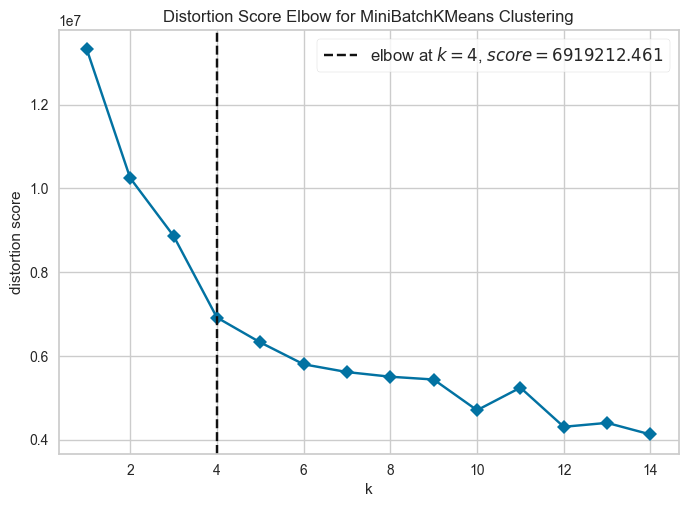

In [ ]:
warnings.filterwarnings("ignore")
model = MiniBatchKMeans(batch_size= 2048)
visualizer = KElbowVisualizer(model, k=(1,15), timings=False)
visualizer.fit(principalDf5_minibatch)
visualizer.show();

In [ ]:
%%time
warnings.filterwarnings("ignore")
MBkmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=6)
principalDf5_minibatch["cluster_mb"] = MBkmeans.fit_predict(principalDf5)
principalDf5_minibatch["cluster_mb"] = principalDf5_minibatch["cluster_mb"].astype("int")

CPU times: total: 266 ms
Wall time: 316 ms


In [ ]:
principalDf5_minibatch.head()

,PC1,PC2,PC3,PC4,PC5,cluster_mb
0,3.03,-3.00,-1.89,0.99,1.59,1
1,-0.26,0.02,-0.95,-0.43,1.10,0
2,1.58,-2.41,-0.33,-0.35,0.74,1
3,-1.82,1.26,-0.38,-0.20,0.42,0
4,4.79,-3.59,-0.82,2.37,-1.69,1


In [ ]:
principalDf5_minibatch["cluster_mb"].value_counts()

0    438471
1    164764
2    118544
3    116782
Name: cluster_mb, dtype: int64

The first actual difference we notice between the MiniBatchKMeans and the other two algorithms we used above is in the execution time: in fact, by construction, as mentioned, MiniBatchKmeans is much more effective in handling a dataset with a large number of observations.

We also have a big difference in the optimal number of clusters proposed by the elbow method: in fact, in MiniBatch the optimal number of clusters is 4. 
Although we have 4 fewer clusters than recommended in the previous two algorithms, the observations are much better distributed among the clusters, particularly compared to Kmeans++ in which clusters 2,3,7 count less than a thousand observations. 

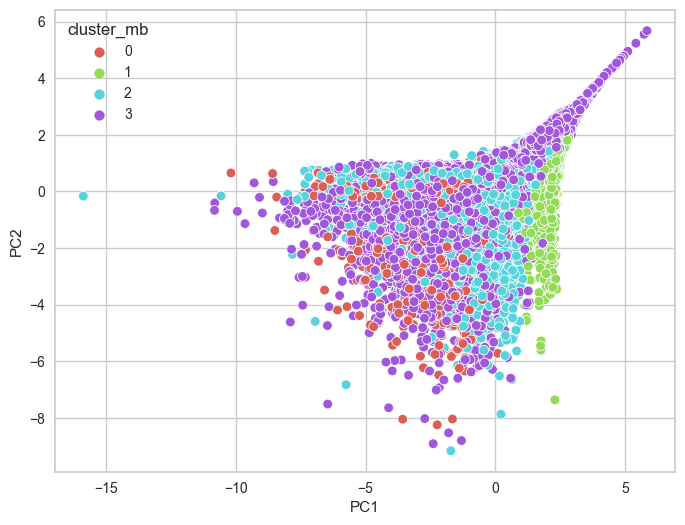

In [ ]:
# 2D
plt.figure(figsize=(8,6))

unique_values = len(principalDf5_minibatch["cluster_mb"].unique())
warnings.filterwarnings("ignore")

sns.scatterplot(x= np.log(principalDf5_minibatch.PC1), 
                y= np.log(principalDf5_minibatch.PC2),
                palette=sns.color_palette('hls', unique_values),
                hue= principalDf5_minibatch["cluster_mb"]);

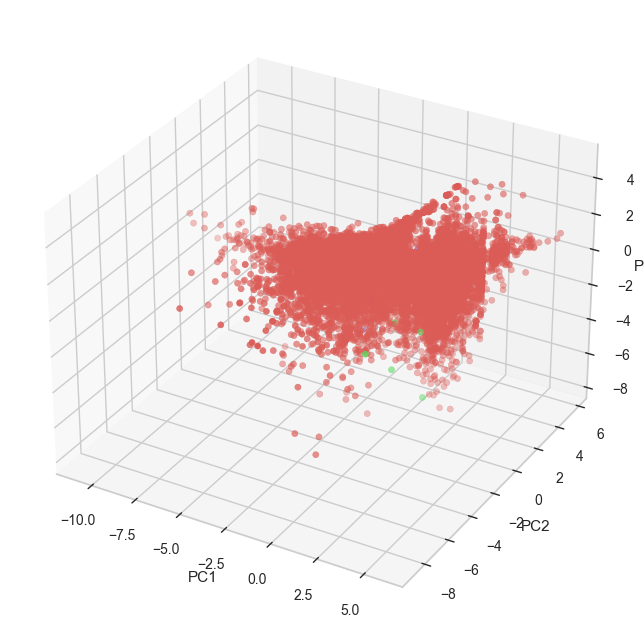

In [ ]:
# 3D graph 
plt.figure(figsize=(10,8))

warnings.filterwarnings("ignore")

unique_values = len(principalDf5_minibatch["cluster_mb"].unique())

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(principalDf5_minibatch.PC1), np.log(principalDf5_minibatch.PC2), np.log(principalDf5_minibatch.PC3), 
           c = principalDf5_minibatch["cluster_mb"],
           cmap = sns.color_palette('hls', unique_values, as_cmap=True))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()

2) BisectingKMeans

K-Means Algorithm has a few limitations:it only identifies spherical shaped clusters (it cannot identify, if the clusters are non-spherical or of various size and density) and it suffers from local minima and has a problem when the data contains outliers.

In our case we are dealing with a dataset that has a fairly substantial amount of outliers (despite the fact that a preliminary analysis has been done to try to eliminate them), so it might be useful to use an algorithm that is robust with respect to the presence of outliers.

So let's use the Bisecting K-Means Algorithm which is a modification of the K-Means algorithm: it is a hybrid approach between partitional and hierarchical clustering, it can recognize clusters of any shape and size and meets more (than the original kmeans) robustness properties.

In [ ]:
from sklearn.cluster import BisectingKMeans

In [ ]:
# let's make a third copy of our principalDf5 dataframe to store these clusters.

principalDf5_bisecting= principalDf5.copy()

In [ ]:
principalDf5_bisecting.head()

,PC1,PC2,PC3,PC4,PC5
0,3.03,-3.00,-1.89,0.99,1.59
1,-0.26,0.02,-0.95,-0.43,1.10
2,1.58,-2.41,-0.33,-0.35,0.74
3,-1.82,1.26,-0.38,-0.20,0.42
4,4.79,-3.59,-0.82,2.37,-1.69


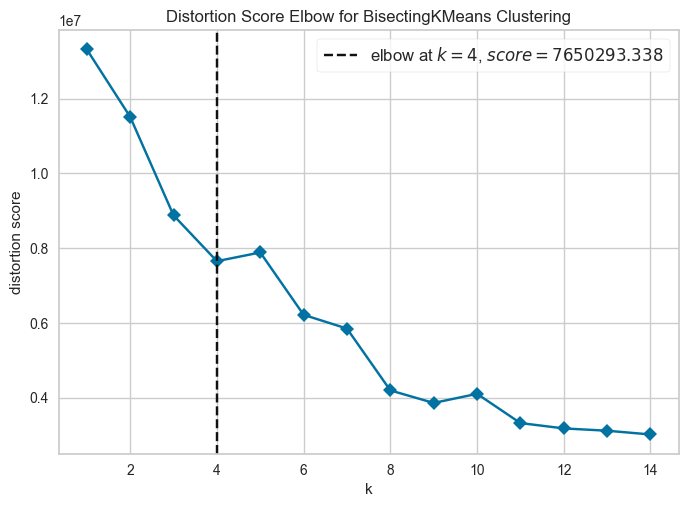

In [ ]:
warnings.filterwarnings("ignore")
model = BisectingKMeans()
visualizer = KElbowVisualizer(model, k=(1,15), timings=False)
visualizer.fit(principalDf5_bisecting)
visualizer.show();

In [ ]:
%%time

BisKmeans = BisectingKMeans(n_clusters=4, random_state=0).fit(principalDf5_bisecting)
labels_bis = BisKmeans.predict(principalDf5_bisecting)
centroids_bisecting = BisKmeans.cluster_centers_

CPU times: total: 4.02 s
Wall time: 958 ms


In [ ]:
principalDf5_bisecting["cluster_bis"] = labels_bis

In [ ]:
principalDf5_bisecting["cluster_bis"].value_counts()

1    514235
3    175924
0    133877
2     14525
Name: cluster_bis, dtype: int64

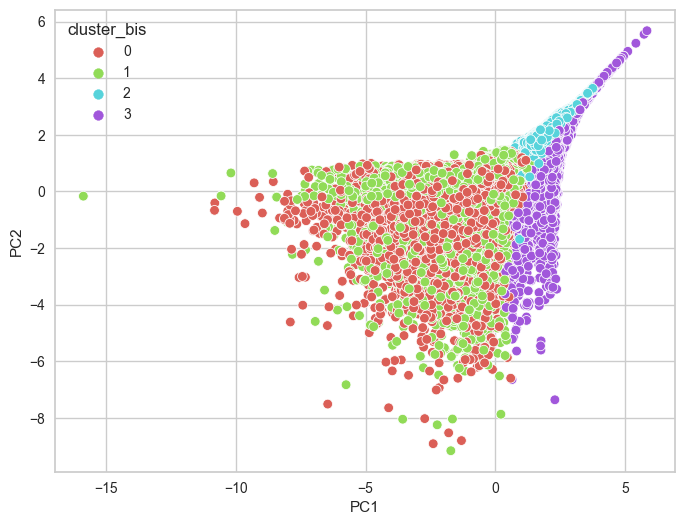

In [ ]:
# 2D graph 
plt.figure(figsize=(8,6))

unique_values = len(principalDf5_bisecting["cluster_bis"].unique())
warnings.filterwarnings("ignore")
sns.scatterplot(x= np.log(principalDf5_bisecting.PC1), 
                y= np.log(principalDf5_bisecting.PC2),
                palette=sns.color_palette('hls', unique_values),
                hue= principalDf5_bisecting["cluster_bis"]);

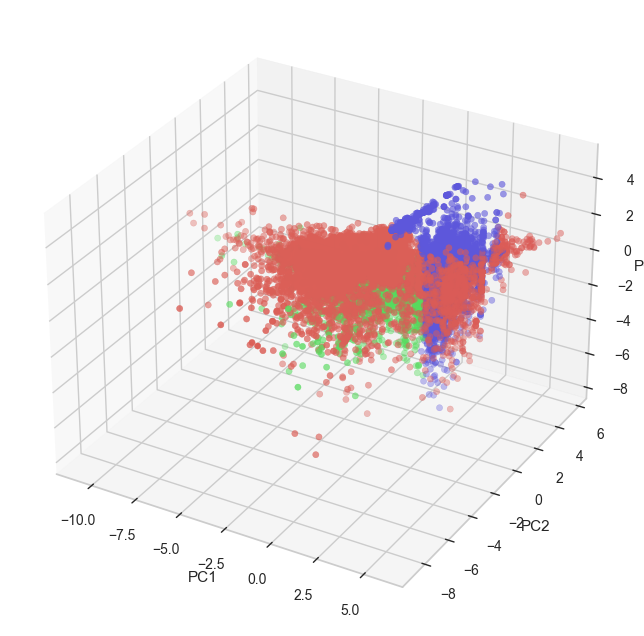

In [ ]:
# 3D graph
plt.figure(figsize=(10,8))

warnings.filterwarnings("ignore")
unique_values = len(principalDf5_bisecting["cluster_bis"].unique())

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(principalDf5_bisecting.PC1), np.log(principalDf5_bisecting.PC2), np.log(principalDf5_bisecting.PC3), 
           c = principalDf5_bisecting["cluster_bis"],
           cmap = sns.color_palette('hls', unique_values, as_cmap=True))

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## 3 - Command Line Question

We also implement the answer to the questions in Python, in order to compare the results obtained in the command line and have a countercheck that the script is working properly. We load the original dataset: 

In [ ]:
banks = pd.read_csv("bank_transactions.csv", delimiter = ",")

In [ ]:
banks.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


### 3.1 - Which location has the maximum number of purchases been made?

The location with the maximum number of transactions been made simply corresponds to the location that appears most frequently in our starting dataset, where each row corresponds to a transaction. So, we just have to find the mode of the column "CustLocation".

In [ ]:
#Return the most common value in CustLocation
banks.CustLocation.mode()

0    MUMBAI
dtype: object

In [ ]:
#How many times did it occur?
banks.CustLocation.value_counts()

MUMBAI                         103595
NEW DELHI                       84928
BANGALORE                       81555
GURGAON                         73818
DELHI                           71019
                                ...  
ROAD (E) THANE                      1
TO APOLO PHARMACY BANGALORE         1
PILLAR NO 725 NEW DELHI             1
COMPANY BANGALORE                   1
IMPERIA THANE WEST                  1
Name: CustLocation, Length: 9355, dtype: int64

So the location in which more transactions have been made is Mumbai, that appears 103595 times.

### 3.2 In the dataset provided, did females spend more than males, or vice versa?

At first, we compute the total expense made by male and female customers simply summing their transaction amounts.

In [ ]:
#Counts the total transaction amount of male customers
banks.groupby('CustGender')['TransactionAmount (INR)'].sum()['M']

1181644838.12

In [ ]:
#Counts the total transaction amount of female customers
banks.groupby('CustGender')['TransactionAmount (INR)'].sum()['F']

466810951.43

So, without knowing how many males and females are in our dataset, we would say that males spent more. Let's check also the number of people per gender and see their respective average expense.

In [ ]:
#Counts the number of customers of all genders
banks.CustGender.value_counts()

M    765530
F    281936
T         1
Name: CustGender, dtype: int64

In [ ]:
#Groups by gender and computes the mean of the transaction amount
banks.groupby('CustGender')['TransactionAmount (INR)'].mean()

CustGender
F     1655.733753
M     1543.564378
T    32500.000000
Name: TransactionAmount (INR), dtype: float64

We see that effectively there are a lot more males than females in out dataset. When we actually compute the arithmetic mean of transaction amount per gender, we see that the average expense of females is greater than the one of males. So females spent more on average.

### 3.3 Report the customer with the highest average transaction amount in the dataset.

In [ ]:
#Computes the maximum average transaction amount of all the dataset
banks.groupby('CustomerID')['TransactionAmount (INR)'].mean().max()

1560034.99

In [ ]:
#Returns the index (here CustomerID) of the customer with maximum average transaction amount
banks.groupby('CustomerID')['TransactionAmount (INR)'].mean().idxmax()

'C7319271'

The requested customer is the one with ID C7319271 and average transaction amount 1560034.99.

### Command Line Results

Below we report the results of the command line execution.

<img src="./img/CommandLineOutput.png" alt="CommandLineOutput">

## 4 - Algorithmic Question

An imaginary university wants to restrict its students' entrance to the campus applying security measures, so each student is assigned a gate through which they should enter the university and each gate must be protected by a guard. Given a priori $N$ entrances, $M$ students and $G$ guards, we provide an algorithm to know whether the number of guards is sufficient to accomplish this task or not. The order in which the students are coming to the university **is known** and is key to the problem's solution.

We make the following assumptions:
- Since we know the sequence of students, we can count how many students we will have per entrance. We need this notion in order to know whenever a guard is free to leave a gate and move to another;
- The number of available guards is our $budget$. Whenever a student arrives to a "new" entrance, we must "spend" a guard to protect the entry. Viceversa, if all the students of a specific entrance have successfully entered the university, the gate is closed and we "regain" a guard that can then be assigned to a new entrance.

We use the following auxiliary variables:
1. `encountered`: list of gates that have been encountered so far. While scanning the students' sequence, we keep track of the gates that we must open depending on the students' order. This helps us to recognize if the current student will actually require assigning a guard to a new entrance or not.
2. `occurrences`: dictionary that stores and updates the number of students expected at each entrance. Every $(key, \space value)$ element of this dictionary associates to the number of the $i-th$ entrance ($i = 1, \space 2, \space ... \space N)$ the quantity of students that are assigned to that entrance. For each student that passes, the corresponding value is decremented.
3. `budget`: integer containing the number of currently available guards. It is decremented whenever a new gate must be opened and reincremented whenever a gate can be closed, as all the expected students already passed. For the algorithm to return "YES", we must always have that $budget \ge 0$, meaning that at most all the guards are busy. We check the budget at every iteration and, as soon as it goes negative, it means we need more guards than we have and the algorithm stops returning "NO".

This is the algorithm pseudo-code:
```
CODE                                              |       COST
for entrance from 1 to N:                         |       # N iterations
  count students per entrance                     |       # O(M)
                                                  |
for student from 1 to M:                          |       # M iterations
  if entrance not encountered:                    |       # O(1)
    budget -= 1                                   |       # O(1)
    mark the entrance as "encountered"            |       # O(1)
    students of that entrance -= 1                |       # O(1) 
    check budget -> eventually return "NO"        |       # O(1)
                 -> eventually increment it       |       # O(1)
  else if entrance encountered:                   |       # O(1)
    students of that entrance -= 1                |       # O(1)
    check budget -> eventually increment it       |       # O(1)
                                                  |
  return "YES" if everything goes well            |       Total: O(N * M) + O(M)
```

This is the algorithm implementation:

In [ ]:
def yes_or_no(n, m, g, s):

  #Count students per entrance
  occurrences = {}                          #create dictionary of occurrences
  for i in range(1, n + 1):                 #for each entrance
    occurrences[i] = s.count(i)             #store the number of expected students

  #Trivial case ---------------------------------------------------------------
  if (g >= n):
    print("YES")
    return
  #Generic case ---------------------------------------------------------------
  else:
    #Initialize
    budget = g                              #number of available guards
    encountered = []                        #keep track of entrances
    #Start
    for i in range(m):                      #scan the sequence of students
      if s[i] not in encountered:           #I need to open a new entrance
        encountered.append(s[i])
        budget -= 1
        occurrences[s[i]] -= 1
        
        #Stop condition
        if budget < 0:
          print("NO")
          return
        
        #Check if the guard is free to go
        if occurrences[s[i]] == 0:
          budget += 1
      else:                                 #the needed gate is already open
        occurrences[s[i]] -= 1
        #Check if the guard is free to go
        if occurrences[s[i]] == 0:
          budget += 1

    #If the algorithm arrives here, the guards are enough
    print("YES")
    return

### Running Time complexity

We see that the function sticks to the expected running time. In the first place we count how many students we have per entrance, and the Python built-in function `count()` is linear in the size of the input, so its cost is $O(M)$. Having to iterate for all $N$ entrances, this first phase takes $N\cdot O(M)$ alone. Then, the checking procedure consists of just one `for` cycle with some constant operations performed every time, so the cost in the worst case will be again $O(M)$ as we need to scan all the elements of the input sequence.

Overall, the computational cost of this implementation is:

$$
N\cdot O(M) + O(M) = O(M) \cdot (N + 1) = O(N \cdot M)
$$

This, for a fixed $N$, reduces to $O(M)$. So the running time complexity of the algorithm is linear in $M$.

### Testing

In the module `script.py` are defined some utility functions that we use here to test the algorithm.

In [ ]:
import script

We start with some simple examples loaded from text files.

In [ ]:
## Try 1 ##
# 4 5 1
# 1 1 3 3 3
N, M, G, students = script.read_from_file("input_1.txt")
yes_or_no(N, M, G, students)

YES


In [ ]:
## Try 2 ##
# 2 5 1
# 1 2 1 2 2
N, M, G, students = script.read_from_file("input_2.txt")
yes_or_no(N, M, G, students)

NO


In [ ]:
## Try 3 ##
# 10 20 4
# 8 3 6 4 9 2 3 4 9 3 2 1 4 9 10 9 2 9 4 4
N, M, G, students = script.read_from_file("input_3.txt")
yes_or_no(N, M, G, students)

YES


Now we want to take a step further. We want to test the algorithm's behaviour as $M$ increases, for fixed $N$ and $G$.

Notice that, in a seemingly contradictory way, the worst case happens when everything goes well: in fact, in order to check that the given combination of parameters actually works and return "YES", we we cannot help but scan the entire sequence of students. There's no alternative to this, because we need to check up until the last student. On the other hand, if $G$ is not high enough the algorithm stops as soon as it finds a negative value for the budget, which most likely happens before the end of the sequence. Hence, in order to compare worst case running times, we need test sequences for which the algorithm returns "YES". What we're going to do is run the algorithm with different input sizes on trivial sequences (defined in `script.py`) to make sure it returns a positive result. We're interested in the asymptotic behaviour, so the important thing is that we force the algorithm to scan the entire sequence in input regardless of how many constant operations are performed at each iteration.

In [ ]:
%%capture
#Run some tests for 10, 50, 100, 500, 1000, 5000, 10000 students
N = 15
M = [10, 50, 100, 500, 1000, 5000, 10000]
G = 10
result = script.testing(N, M, G)

In [ ]:
#Display the running time for the Ms of interest
script.print_results(M, result)

Running time with 10 students: 1.6927719116210938e-05
Running time with 50 students: 3.457069396972656e-05
Running time with 100 students: 6.961822509765625e-05
Running time with 500 students: 0.00033020973205566406
Running time with 1000 students: 0.0005662441253662109
Running time with 5000 students: 0.005103588104248047
Running time with 10000 students: 0.012692928314208984


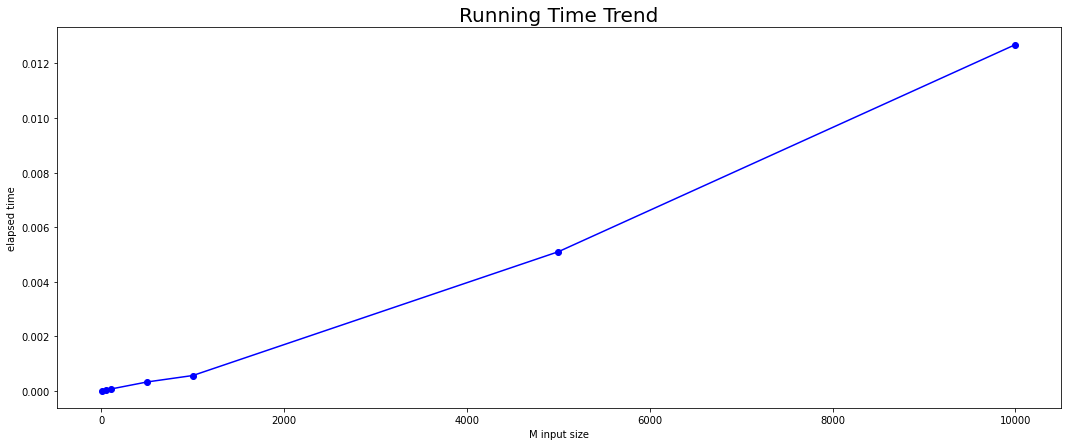

In [ ]:
#Visualize the running time for different input sizes
plt.figure(figsize = (18, 7))
plt.plot(M, result, linestyle='-', marker='o', color = 'blue')
plt.title('Running Time Trend', fontsize = 20)
plt.xlabel('M input size')
plt.ylabel('elapsed time')
plt.show()

We observe that the execution time actually shows a linear growth with respect to the size of the input.